# PLOD-CW NER Tag Sequence Labelling

## Imports & Setup

In [1]:
import json
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import torchtext
import tqdm
import pandas as pd
import sklearn.metrics
import os
from datasets import load_dataset
from collections import OrderedDict
from datetime import datetime
from matplotlib import pyplot as plt
from pycm import ConfusionMatrix
import gensim
import datasets
from collections import Counter
import seaborn as sns
from typing import List
from seqeval.metrics import classification_report, f1_score
from seqeval.scheme import IOB2

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'}.")

Using GPU.


In [3]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
sos_token = "<sos>"
eos_token = "<eos>"
unk_token = "<unk>"
pad_token = "<pad>"

ner_tags = ['B-O', 'B-AC', 'B-LF', 'I-LF']
pos_tags = ["ADJ", "ADP", "ADV", "AUX", "CCONJ", "DET", "INTJ", "NOUN", "NUM", "PART", "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X"]

### Training or Evaluation Flag

Set the `TRAIN` flag to `True` to train the models within the experiments, or `False` to load pre-trained models and evaluate them.

In [5]:
TRAIN = True

## Preprocessing functions

In [6]:
def tokenize_sample(sample, lower, sos_token, eos_token):
    tokens = sample["tokens"]
    ner_tags = sample["ner_tags"]
    pos_tags = sample["pos_tags"]
    
    if lower:
        tokens = [t.lower() for t in tokens]
    
    tokens = [sos_token] + tokens + [eos_token]
    ner_tags = [sos_token] + ner_tags + [eos_token]
    pos_tags = [sos_token] + pos_tags + [eos_token]

    return {"tokens": tokens, "ner_tags": ner_tags, "pos_tags": pos_tags}


In [7]:
def tokenize_datasets(train, val, test, lower):
    
    fn_kwargs = {
        "lower": lower,
        "sos_token": sos_token,
        "eos_token": eos_token
    }
    
    train = train.map(tokenize_sample, fn_kwargs=fn_kwargs)
    val = val.map(tokenize_sample, fn_kwargs=fn_kwargs)
    test = test.map(tokenize_sample, fn_kwargs=fn_kwargs)
    
    return train, val, test

In [8]:
def create_word2vec_vector_file():
    # check if GoogleNews-vectors-negative300 is located in ./vector_cache
    if not os.path.isfile("./.vector_cache/GoogleNews-vectors-negative300.bin"):
        raise ValueError("Pretrained word2vec embeddings not found. Please download GoogleNews-vectors-negative300.bin and place it in the .vector_cache directory.")
    # load with gensim
    gensim_model = gensim.models.KeyedVectors.load_word2vec_format("./.vector_cache/GoogleNews-vectors-negative300.bin", binary=True)
    # construct dict
    token_vectors = {word: torch.tensor(gensim_model[word]) for word in gensim_model.index_to_key}
    # write this to a text file
    # word vec[0] vec[1] ... vec[n]
    with open("./.vector_cache/word2vec.300d.txt", "w", encoding="utf-8") as f:
        for word, vec in token_vectors.items():
            vec_str = " ".join([str(x) for x in vec.tolist()])
            f.write(f"{word} {vec_str}\n")

In [9]:
def build_vocabularies(max_size, vocab_name, pretrained_emb: bool, train_data):

    pretrained_embeddings = None

    if vocab_name is not None:
        if vocab_name in ["glove", "fasttext", "word2vec"]:
            if vocab_name == "glove":
                token_vectors = torchtext.vocab.GloVe(name="6B", dim=100, max_vectors=max_size)
            elif vocab_name == "fasttext":
                token_vectors = torchtext.vocab.FastText(language="en", max_vectors=max_size)
            else:
                # check if word2vec file exists
                if not os.path.isfile("./.vector_cache/word2vec.300d.txt"):
                    print("Word2Vec embeddings not found. Creating file... This may take a while.")
                    create_word2vec_vector_file()
                token_vectors = torchtext.vocab.Vectors(name="word2vec.300d.txt", max_vectors=max_size)
        else:
            raise ValueError("Vocabulary name must be one of 'glove', 'fasttext', or 'word2vec'.")

        token_vocab = torchtext.vocab.vocab(
                token_vectors.stoi,
                min_freq=0,
                specials=[pad_token, unk_token, sos_token, eos_token],
                special_first=True
            )

        if pretrained_emb:
            pretrained_embeddings = token_vectors.vectors
            pretrained_embeddings = torch.cat([
                torch.empty(1, token_vectors.dim).normal_(),  # unk token vector
                torch.zeros(1, token_vectors.dim),  # padding token vector
                pretrained_embeddings
            ])
    else:
        if pretrained_emb:
            raise ValueError("Pretrained embeddings can only be used with GloVe, FastText, or word2vec vocabularies.")

        token_vocab = torchtext.vocab.build_vocab_from_iterator(
            train_data["tokens"],
            min_freq=1,
            specials=[pad_token, unk_token, sos_token, eos_token],
            special_first=True,
            max_tokens=max_size
        )

    token_vocab.set_default_index(token_vocab[unk_token])

    ner_tag_vocab = torchtext.vocab.vocab(OrderedDict([(tag, 1) for _, tag in enumerate(ner_tags)]), specials=[pad_token, sos_token, eos_token], special_first=True)

    pos_tag_vocab = torchtext.vocab.vocab(OrderedDict([(tag, 1) for _, tag in enumerate(pos_tags)]), specials=[pad_token, sos_token, eos_token], special_first=True)

    assert token_vocab[pad_token] == ner_tag_vocab[pad_token] == pos_tag_vocab[pad_token], "Pad tokens must have the same index in all vocabularies."

    return token_vocab, pretrained_embeddings, ner_tag_vocab, pos_tag_vocab


# special tags shouldn't be included in the metrics
#   <pad>: ind 0
#   <sos>: ind 1
#   <eos>: ind 2
ner_tag_vocab_indexes = [3, 4, 5, 6]

In [10]:
def numericalize_sample(sample, token_vocab, ner_tag_vocab, pos_tag_vocab):
    tokens = sample["tokens"]
    ner_tags = sample["ner_tags"]
    pos_tags = sample["pos_tags"]

    token_ids = token_vocab.lookup_indices(tokens)
    ner_tag_ids = ner_tag_vocab.lookup_indices(ner_tags)
    pos_tag_ids = pos_tag_vocab.lookup_indices(pos_tags)

    return {"tokens": token_ids, "ner_tags": ner_tag_ids, "pos_tags": pos_tag_ids}


In [11]:
def numericalize_dataset(train, val, test, token_vocab, ner_tag_vocab, pos_tag_vocab):
    
    fn_kwargs = {
        "token_vocab": token_vocab,
        "ner_tag_vocab": ner_tag_vocab,
        "pos_tag_vocab": pos_tag_vocab
    }
    
    train_data_numd = train.map(numericalize_sample, fn_kwargs=fn_kwargs)
    val_data_numd = val.map(numericalize_sample, fn_kwargs=fn_kwargs)
    test_data_numd = test.map(numericalize_sample, fn_kwargs=fn_kwargs)
    
    return train_data_numd, val_data_numd, test_data_numd

In [12]:
def torchify(train, val, test):
    data_type = "torch"
    format_columns = ["tokens", "ner_tags", "pos_tags"]
    
    train = train.with_format(data_type, columns=format_columns, output_all_columns=True)
    val = val.with_format(data_type, columns=format_columns, output_all_columns=True)
    test = test.with_format(data_type, columns=format_columns, output_all_columns=True)
    
    return train, val, test

In [13]:
def get_collate_fn(pad_idx):
    def collate_fn(batch):
        tokens = [item["tokens"] for item in batch]
        ner_tags = [item["ner_tags"] for item in batch]
        pos_tags = [item["pos_tags"] for item in batch]

        tokens = nn.utils.rnn.pad_sequence(tokens, padding_value=pad_idx)
        ner_tags = nn.utils.rnn.pad_sequence(ner_tags, padding_value=pad_idx)
        pos_tags = nn.utils.rnn.pad_sequence(pos_tags, padding_value=pad_idx)
        batch = {
            "tokens": tokens,
            "ner_tags": ner_tags,
            "pos_tags": pos_tags
        }
        return batch
    return collate_fn

In [14]:
def get_data_loader(dataset, batch_size, pad_idx, shuffle=False):
    collate_fn = get_collate_fn(pad_idx)
    return torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn
    )

In [15]:
def get_data_loaders(max_vocab_size, vocab_name, pretrained_emb, train_data, val_data, test_data, batch_size):

    # tokenize
    train_data_tok, val_data_tok, test_data_tok = tokenize_datasets(train_data, val_data, test_data, lower=True)

    # build vocabularies
    token_vocab, pretrained_embeddings, ner_tag_vocab, pos_tag_vocab = build_vocabularies(max_vocab_size, vocab_name, pretrained_emb, train_data)

    # numericalize
    train_data_numd, val_data_numd, test_data_numd = numericalize_dataset(train_data_tok, val_data_tok, test_data_tok, token_vocab, ner_tag_vocab, pos_tag_vocab)

    # torchify
    train_data_numd, val_data_numd, test_data_numd = torchify(train_data_numd, val_data_numd, test_data_numd)

    pad_idx = token_vocab["<pad>"]

    # get data loaders
    train_data_loader = get_data_loader(train_data_numd, batch_size, pad_idx, shuffle=True)
    val_data_loader = get_data_loader(val_data_numd, batch_size, pad_idx)
    test_data_loader = get_data_loader(test_data_numd, batch_size, pad_idx)

    return train_data_loader, val_data_loader, test_data_loader, pretrained_embeddings, token_vocab, ner_tag_vocab, pos_tag_vocab


## Model Architecture & Training Functions

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, pos_dim, emb_dim, hid_dim, n_layers, dropout, rnn_type,  bidirectional=False, pretrained_embeddings=None):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.rnn_type = rnn_type
        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        else:
            self.embedding = nn.Embedding(input_dim, emb_dim)

        self.pos_embedding = nn.Embedding(pos_dim, emb_dim)

        if rnn_type == "rnn":
            self.rnn = nn.RNN(2 * emb_dim, hid_dim, n_layers, dropout=dropout, bidirectional=bidirectional)
        elif rnn_type == "lstm":
            self.rnn = nn.LSTM(2 * emb_dim, hid_dim, n_layers, dropout=dropout, bidirectional=bidirectional)
        elif rnn_type == "gru":
            self.rnn = nn.GRU(2 * emb_dim, hid_dim, n_layers, dropout=dropout, bidirectional=bidirectional)
        else:
            raise ValueError("rnn_type must be one of 'rnn', 'lstm', or 'gru'")

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, pos):
        embedded = self.dropout(self.embedding(src))
        pos_embedded = self.dropout(self.pos_embedding(pos))
        combined = torch.cat((embedded, pos_embedded), dim=2)
        if self.rnn_type == "lstm":
            outputs, (hidden, cell) = self.rnn(combined)
        else:
            outputs, hidden = self.rnn(combined)
        # when bidirectional, hidden is of shape (num_layers * num_directions, batch, hidden_size)
        # decoder is unidirectional, so we need to concatenate the forward and backward hidden states
        # destination shape should be (num_layers, batch, hidden_size * num_directions)

        if self.rnn.bidirectional:
            # concat the backward directions onto the forward directions
            # this allows for a unidirectional decoder to be used with hidden_dim * 2
            hidden = torch.cat((hidden[:self.n_layers, :, :], hidden[self.n_layers:, :, :]), dim=-1)
            if self.rnn_type == "lstm":
                cell = torch.cat((cell[:self.n_layers, :, :], cell[self.n_layers:, :, :]), dim=-1)

        if self.rnn_type == "lstm":
            return hidden, cell
        else:
            return hidden

In [17]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout, rnn_type, bidirectional=False, pretrained_embeddings=None):
        super().__init__()
        
        hid_dim = hid_dim * 2 if bidirectional else hid_dim

        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.rnn_type = rnn_type

        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        else:
            self.embedding = nn.Embedding(output_dim, emb_dim)
        
        if rnn_type == "rnn":
            self.rnn = nn.RNN(emb_dim, hid_dim, n_layers, dropout=dropout)
        elif rnn_type == "lstm":
            self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        elif rnn_type == "gru":
            self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout)
        else:
            raise ValueError("rnn_type must be one of 'rnn', 'lstm', or 'gru'")
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell=None):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        if self.rnn_type == "lstm":
            output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        else:
            output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output.squeeze(0))
        
        if self.rnn_type == "lstm":
            return prediction, hidden, cell
        else:
            return prediction, hidden

In [18]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, rnn_type):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.rnn_type = rnn_type

        # assert encoder.hid_dim == decoder.hid_dim, "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, "Encoder and decoder must have equal number of layers!"

    def forward(self, src, pos, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        if self.rnn_type == "lstm":
            hidden, cell = self.encoder(src, pos)
        else:
            hidden = self.encoder(src, pos)

        input = trg[0, :]

        for t in range(1, trg_len):
            if self.rnn_type == "lstm":
                output, hidden, cell = self.decoder(input, hidden, cell)
            else:
                output, hidden = self.decoder(input, hidden)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

In [19]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [21]:
def build_model(input_dim, pos_dim, output_dim, emb_dim, hid_dim, n_layers, dropout, bidirectional, pretrained_embeddings, device, rnn_type, suppress_output=False):
    encoder = Encoder(input_dim, pos_dim, emb_dim, hid_dim, n_layers, dropout, rnn_type, bidirectional=bidirectional, pretrained_embeddings=pretrained_embeddings)
    decoder = Decoder(output_dim, emb_dim, hid_dim, n_layers, dropout, rnn_type, bidirectional=bidirectional, pretrained_embeddings=pretrained_embeddings)
    model = Seq2Seq(encoder, decoder, device, rnn_type).to(device)

    model.apply(init_weights)

    params = count_parameters(model)
    if not suppress_output:
        print(f"The model has {params:,} trainable parameters.")

    model_config = {
        "input_dim": input_dim,
        "pos_dim": pos_dim,
        "output_dim": output_dim,
        "emb_dim": emb_dim,
        "hid_dim": hid_dim,
        "n_layers": n_layers,
        "dropout": dropout,
        "bidirectional": bidirectional,
        "parameters": params,
        "rnn_type": rnn_type
    }


    return model, model_config

In [22]:
def train(model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(data_loader):
        src = batch["tokens"].to(device)
        pos = batch["pos_tags"].to(device)
        trg = batch["ner_tags"].to(device)
        
        optimizer.zero_grad()
        output = model(src, pos, trg, teacher_forcing_ratio)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(data_loader)

In [23]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    
    actuals = []
    predictions = []

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["tokens"].to(device)
            pos = batch["pos_tags"].to(device)
            trg = batch["ner_tags"].to(device)
            
            output = model(src, pos, trg, 0)
            trg = trg[1:]
            
            output_argmax = output[1:].argmax(2)
            # vertically slice to get each item in the batch
            for j in range(output_argmax.shape[1]):
                actual = trg[:, j]
                # actual values are padded with 0s (<pad> token) so we remove them
                actual = actual[actual != 0].tolist()
                actuals.extend(actual)
                # using the length of the actual values to slice the predicted values
                prediction = output_argmax[:, j][:len(actual)].tolist()
                predictions.extend(prediction)
            
            output = output[1:].view(-1, output.shape[-1])
            trg = trg.view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()    
            
    # calculate class metrics
    accuracy = sklearn.metrics.accuracy_score(actuals, predictions)
    precision, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(
        actuals, 
        predictions, 
        average=None,
        labels=ner_tag_vocab_indexes,
        zero_division=0
    )
    
    return epoch_loss / len(data_loader), accuracy, precision, recall, f1, support

In [24]:
def train_loop(model, train_loader, val_loader, optimizer, criterion, clip, teacher_forcing_ratio, device, n_epochs, model_config, output_directory="output"):

    # format model_name with current date and time
    model_name = f"model_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}"
    model_file_path = f"{output_directory}/{model_name}.pt"
    # check if output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # add missing model_config values
    model_config["n_epochs"] = n_epochs
    model_config["clip"] = clip
    model_config["teacher_forcing_ratio"] = teacher_forcing_ratio
    model_config["optimizer"] = str(optimizer)
    model_config["loss_function"] = str(criterion)
    model_config["class_labels"] = ner_tags

    metrics = {}

    best_val_loss = float("inf")

    with tqdm.tqdm(total=n_epochs) as pbar:
        for epoch in range(n_epochs):
            train_loss = train(model, train_loader, optimizer, criterion, clip, teacher_forcing_ratio, device)
            val_loss, accuracy, precision, recall, f1, support = evaluate(model, val_loader, criterion, device)

            metrics[f"epoch_{epoch}"] = {
                "train_loss": train_loss,
                "val_loss": val_loss,
                "accuracy": accuracy,
                "precision": precision.tolist(),
                "recall": recall.tolist(),
                "f1": f1.tolist(),
                "support": support.tolist(),
            }

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_file_path)

            class_f1 = {k: v for k, v in zip(ner_tags, f1)}

            overall_f1 = (f1 * support).sum() / support.sum()

            pbar.set_postfix(t_loss=train_loss, v_loss=val_loss, **class_f1, f1=overall_f1)
            pbar.update(1)

    output_metrics = {
        "model_config": model_config,
        "metrics": metrics
    }

    with open(f"{output_directory}/metrics_{model_name}.json", "w") as f:
        json.dump(output_metrics, f, indent=4)

    return model_file_path

## Test & Evaluation Functions

In [25]:
def load_model_checkpoint(model, model_file_path):
    # load best model
    model_file = os.path.basename(model_file_path)
        
    model_date_time = model_file[model_file.find("_")+1:model_file.find(".")]
    age = datetime.now() - datetime.strptime(model_date_time, "%Y%m%d_%H%M%S")
    print(f"Using model file: {model_file}, age: {age.total_seconds()/60 :.2f} minutes")
    
    model.load_state_dict(torch.load(model_file_path))
    
    return model

In [26]:
# function to obtain f1 score from test data
def test_model(model, test_loader, criterion, device, return_metrics=False):   
    test_loss, accuracy, precision, recall, f1, support = evaluate(model, test_loader, criterion, device)
        
    overall_f1 = (f1 * support).sum() / support.sum()
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")  
    print(f"Overall F1: {overall_f1:.4f}")
        
    display(pd.DataFrame({
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "support": support
    }, index=ner_tags))
    
    if return_metrics:
        return test_loss, accuracy, precision, recall, f1, support, overall_f1        

In [27]:
def predict_dataloader(model, data_loader, device):
    model.eval()
    actuals = []
    predictions = []

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["tokens"].to(device)
            pos = batch["pos_tags"].to(device)
            trg = batch["ner_tags"].to(device)
            
            output = model(src, pos, trg, 0)
            output = output[1:].argmax(2)
            trg = trg[1:]
            
            # vertically slice to get each item in the batch
            for j in range(output.shape[1]):
                actual = trg[:, j]
                # actual values are padded with 0s (<pad> token) so we remove them
                actual = actual[actual != 0].tolist()
                actuals.append(actual)
                # using the length of the actual values to slice the predicted values
                prediction = output[:, j][:len(actual)].tolist()
                predictions.append(prediction)

    return actuals, predictions

In [28]:
# function to output confusion matrix, from model object
def confusion_matrix(model, test_loader, device):
    actuals, predictions = predict_dataloader(model, test_loader, device)
    
    actuals_bio = [[ner_tag_vocab.lookup_token(tag) for tag in sample] for sample in actuals]
    predictions_bio = [[ner_tag_vocab.lookup_token(tag) for tag in sample] for sample in predictions]
    
    actuals_flat = [tag for sample in actuals_bio for tag in sample]
    predictions_flat = [tag for sample in predictions_bio for tag in sample]
    
    cm = ConfusionMatrix(actual_vector=actuals_flat, predict_vector=predictions_flat, classes=ner_tag_vocab.lookup_tokens(ner_tag_vocab_indexes))
    
    return cm

In [29]:
def plot_cm(model, test_data_loader, device, exp_num, name):
    cm = confusion_matrix(model, test_data_loader, device)
    ax = cm.plot(cmap=plt.cm.Blues, 
                 number_label=True, 
                 plot_lib="matplotlib", 
                 normalized=True,
                 title=f"{name} Confusion Matrix")
    # save ax image
    plt.grid(False)
    plt.savefig(f"output/figures/exp{exp_num}_cm_{name}_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.png")

In [30]:
def plot_metrics(model_file_path, exp_num, name):
    metrics_file_path = f"output/metrics_{os.path.basename(model_file_path).replace('.pt', '.json')}"
    with open(metrics_file_path, "r") as f:
        metrics = json.load(f)

    display(metrics["model_config"])

    # plot f1 scores
    f1_scores = [metrics["metrics"][f"epoch_{i}"]["f1"] for i in range(metrics["model_config"]["n_epochs"])]

    epochs = range(metrics["model_config"]["n_epochs"])
    for i in range(len(f1_scores[0])):
        plt.plot(epochs, [f1[i] for f1 in f1_scores], label=metrics["model_config"]["class_labels"][i])

    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title(f"{name} - F1 Scores")
    plt.legend()
    plt.grid(False)
    plt.savefig(f"output/figures/exp{exp_num}_f1_{name}_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.png")
    plt.show()

    # plot losses
    train_losses = [metrics["metrics"][f"epoch_{i}"]["train_loss"] for i in range(metrics["model_config"]["n_epochs"])]
    val_losses = [metrics["metrics"][f"epoch_{i}"]["val_loss"] for i in range(metrics["model_config"]["n_epochs"])]
    epochs = range(metrics["model_config"]["n_epochs"])

    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{name} - Losses")
    plt.legend()
    plt.grid(False)
    plt.savefig(f"output/figures/exp{exp_num}_loss_{name}_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.png")
    plt.show()

In [45]:
def evaluate_seqeval(model, data_loader, device, ner_tag_vocab, suppress_report=False, return_macro_average=False):
    actuals, predicted = predict_dataloader(model, data_loader, device)
    #                                                                [:-1] to strip off <eos> tag
    actuals_bio = [[ner_tag_vocab.lookup_token(tag) for tag in sample[:-1]] for sample in actuals]
    predictions_bio = [[ner_tag_vocab.lookup_token(tag) for tag in sample[:-1]] for sample in predicted]

    if not suppress_report:
        print(classification_report(actuals_bio, predictions_bio, scheme=IOB2, zero_division=0))

    if return_macro_average:
        return round(f1_score(actuals_bio, predictions_bio, average='macro', scheme=IOB2, zero_division=0), 2)

## Data Exploration & Visualization

In [33]:
# load dataset
dataset = load_dataset("surrey-nlp/PLOD-CW")
dataset.column_names

{'train': ['tokens', 'pos_tags', 'ner_tags'],
 'validation': ['tokens', 'pos_tags', 'ner_tags'],
 'test': ['tokens', 'pos_tags', 'ner_tags']}

In [31]:
# table of ner tag distribution by split
train_data, val_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"]
)

train_ner_tag_counts = Counter([tag for tags in train_data["ner_tags"] for tag in tags])
val_ner_tag_counts = Counter([tag for tags in val_data["ner_tags"] for tag in tags])
test_ner_tag_counts = Counter([tag for tags in test_data["ner_tags"] for tag in tags])

ner_tag_counts = pd.DataFrame({
    "train": train_ner_tag_counts,
    "val": val_ner_tag_counts,
    "test": test_ner_tag_counts
})

# add total column
ner_tag_counts["total"] = ner_tag_counts.sum(axis=1)
ner_tag_counts

,train,val,test,total
B-O,32971,4261,4292,41524
B-LF,1462,149,150,1761
I-LF,3231,327,288,3846
B-AC,2336,263,270,2869


In [32]:
# table but with relative percentages
ner_tag_counts_rel = ner_tag_counts.div(ner_tag_counts.sum()) * 100
ner_tag_counts_rel = ner_tag_counts_rel.round(2).astype(str) + "%"
ner_tag_counts_rel

,train,val,test,total
B-O,82.43%,85.22%,85.84%,83.05%
B-LF,3.66%,2.98%,3.0%,3.52%
I-LF,8.08%,6.54%,5.76%,7.69%
B-AC,5.84%,5.26%,5.4%,5.74%


In [33]:
# combine dataset splits for exploration
combined_dataset = load_dataset("surrey-nlp/PLOD-CW", split=datasets.Split.ALL)
# convert to pandas dataframe
df = pd.DataFrame(combined_dataset)
df.head()

,tokens,pos_tags,ner_tags
0,"[For, this, purpose, the, Gothenburg, Young, P...","[ADP, DET, NOUN, DET, PROPN, PROPN, PROPN, PRO...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I..."
1,"[The, following, physiological, traits, were, ...","[DET, ADJ, ADJ, NOUN, AUX, VERB, PUNCT, ADJ, N...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF..."
2,"[Minor, H, antigen, alloimmune, responses, rea...","[ADJ, PROPN, NOUN, ADJ, NOUN, ADV, VERB, ADP, ...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,..."
3,"[EPI, =, Echo, planar, imaging, .]","[PROPN, PUNCT, NOUN, NOUN, NOUN, PUNCT]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]"
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[ADV, PUNCT, PROPN, PUNCT, VERB, PROPN, NOUN, ...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O..."


In [2]:
# create output directrories if not already exist
if not os.path.exists("output/figures/vis"):
    os.makedirs("output/figures/vis")

### NER Tag Distribution

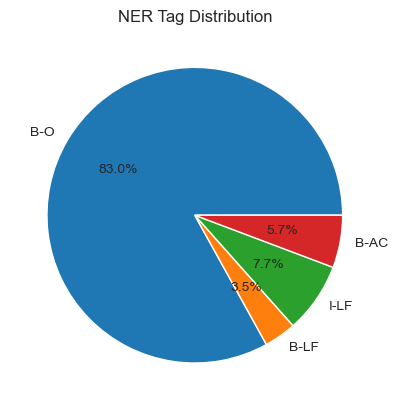

In [34]:
# count the number of each NER tag across dataset
ner_tag_counts = Counter([tag for tags in df["ner_tags"] for tag in tags])
plt.pie(ner_tag_counts.values(), labels=ner_tag_counts.keys(), autopct='%1.1f%%')
plt.title("NER Tag Distribution")
plt.savefig("output/figures/vis/ner_tag_distribution_pie.png")
plt.show()

### Long Form Token Lengths

In [35]:
def get_long_form_tokens_length(sample) -> List[int]:
    lengths = []
    long_form_length = 0
    for tag in sample["ner_tags"]:
        if tag == "B-LF" or tag == "I-LF":
            long_form_length += 1
        else:
            if long_form_length > 0:
                lengths.append(long_form_length)
                long_form_length = 0
    
    return lengths

In [36]:
df["long_form_lengths"] = df.apply(get_long_form_tokens_length, axis=1)
df["long_form_lengths"].head()

0             [5]
1    [2, 2, 3, 3]
2          [3, 3]
3             [3]
4          [1, 7]
Name: long_form_lengths, dtype: object

In [37]:
# count the number of each length of long form tokens across dataset
long_form_lengths = [length for lengths in df["long_form_lengths"] for length in lengths]
long_form_lengths_count = Counter(long_form_lengths)
long_form_lengths_count

Counter({3: 561,
         2: 471,
         4: 279,
         1: 208,
         5: 136,
         6: 73,
         7: 31,
         8: 17,
         9: 7,
         10: 6,
         11: 3,
         14: 1,
         17: 1})

C:\Users\evan9\anaconda3\envs\nlp2024\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\evan9\anaconda3\envs\nlp2024\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\evan9\anaconda3\envs\nlp2024\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\evan9\anaconda3\envs\nlp2024\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categori

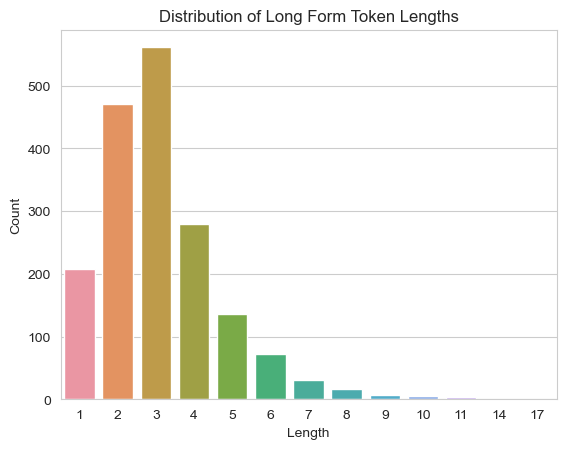

In [38]:
# plot the distribution of long form token lengths
fig = sns.barplot(x=list(long_form_lengths_count.keys()), y=list(long_form_lengths_count.values())).set(title="Distribution of Long Form Token Lengths", xlabel="Length", ylabel="Count")
plt.savefig("output/figures/vis/long_form_token_lengths.png")


## Experiments

### Experiment 1

This experiment focuses on using different RNN cell types in the encoder and decoder, and comparing the results. 

In [273]:
dataset = load_dataset("surrey-nlp/PLOD-CW")
dataset.column_names

{'train': ['tokens', 'pos_tags', 'ner_tags'],
 'validation': ['tokens', 'pos_tags', 'ner_tags'],
 'test': ['tokens', 'pos_tags', 'ner_tags']}

In [274]:
train_data, val_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"]
)
pd.DataFrame(train_data[0]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,For,this,purpose,the,Gothenburg,Young,Persons,Empowerment,Scale,(,GYPES,),was,developed,.
pos_tags,ADP,DET,NOUN,DET,PROPN,PROPN,PROPN,PROPN,PROPN,PUNCT,PROPN,PUNCT,AUX,VERB,PUNCT
ner_tags,B-O,B-O,B-O,B-O,B-LF,I-LF,I-LF,I-LF,I-LF,B-O,B-AC,B-O,B-O,B-O,B-O


In [275]:
# build data loaders
max_vocab_size = 25_000
vocab_name = None
pretrained_emb = False
batch_size = 64

train_data_loader, val_data_loader, test_data_loader, pretrained_embeddings, token_vocab, ner_tag_vocab, pos_tag_vocab = get_data_loaders(max_vocab_size, vocab_name, pretrained_emb, train_data, val_data, test_data, batch_size)

#### Experiment 1.1: RNN Cells

In [276]:
# call build_model
model, model_config = build_model(
    input_dim=len(token_vocab),
    pos_dim=len(pos_tag_vocab),
    output_dim=len(ner_tag_vocab),
    emb_dim=100,
    hid_dim=256,
    n_layers=2,
    dropout=0.5,
    bidirectional=True,
    pretrained_embeddings=pretrained_embeddings,
    device=DEVICE,
    rnn_type="rnn"
)

# add vocab params to model_config
model_config["vocab_name"] = vocab_name
model_config["max_vocab_size"] = max_vocab_size
model_config["pretrained_emb"] = pretrained_emb
model_config["batch_size"] = batch_size

The model has 2,388,407 trainable parameters.


In [277]:
# define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=ner_tag_vocab["<pad>"])

In [284]:
if TRAIN:
    # train model
    model_file_path = train_loop(
        model=model,
        train_loader=train_data_loader,
        val_loader=val_data_loader,
        optimizer=optimizer,
        criterion=criterion,
        clip=1,
        teacher_forcing_ratio=0.5,
        device=DEVICE,
        n_epochs=55,
        model_config=model_config
    )
else:
    model_file_path = "output/model_20240410_183959.pt"

In [285]:
# model_file_path = "output/model_20240410_183959.pt"
# load best model
model = load_model_checkpoint(model, model_file_path)

Using model file: model_20240410_183959.pt, age: 9871.46 minutes


In [286]:
# run test_model
test_model(model, test_data_loader, criterion, DEVICE)

Test Loss: 0.5910
Accuracy: 0.8446
Overall F1: 0.8444


,precision,recall,f1,support
B-O,0.882655,0.960391,0.919884,4292
B-AC,0.531429,0.344444,0.417978,270
B-LF,0.366337,0.246667,0.294821,150
I-LF,0.485437,0.347222,0.404858,288


In [287]:
evaluate_seqeval(model, test_data_loader, DEVICE, ner_tag_vocab)

              precision    recall  f1-score   support

          AC       0.59      0.34      0.43       270
          LF       0.25      0.16      0.20       152
           O       0.91      0.96      0.93      4292
        eos>       0.00      0.00      0.00         0

   micro avg       0.88      0.90      0.89      4714
   macro avg       0.44      0.37      0.39      4714
weighted avg       0.87      0.90      0.88      4714



C:\Users\evan9\anaconda3\envs\nlp2024\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: <eos> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


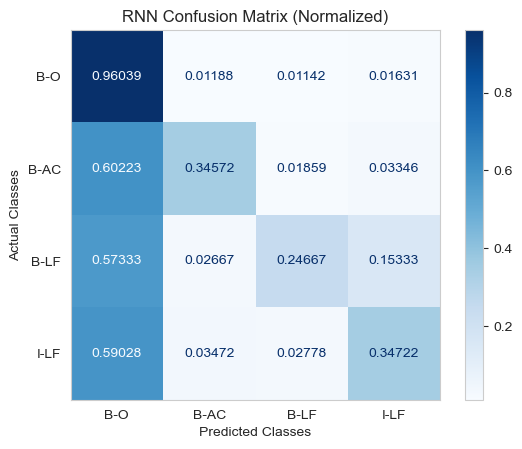

In [175]:
plot_cm(model, test_data_loader, DEVICE, 1, "RNN")

{'input_dim': 9137,
 'pos_dim': 20,
 'output_dim': 7,
 'emb_dim': 100,
 'hid_dim': 256,
 'n_layers': 2,
 'dropout': 0.5,
 'bidirectional': True,
 'parameters': 2388407,
 'rnn_type': 'rnn',
 'vocab_name': None,
 'max_vocab_size': 25000,
 'pretrained_emb': False,
 'batch_size': 64,
 'n_epochs': 55,
 'clip': 1,
 'teacher_forcing_ratio': 0.5,
 'optimizer': 'Adam (\nParameter Group 0\n    amsgrad: False\n    betas: (0.9, 0.999)\n    eps: 1e-08\n    lr: 0.001\n    maximize: False\n    weight_decay: 0\n)',
 'loss_function': 'CrossEntropyLoss()',
 'class_labels': ['B-O', 'B-AC', 'B-LF', 'I-LF']}

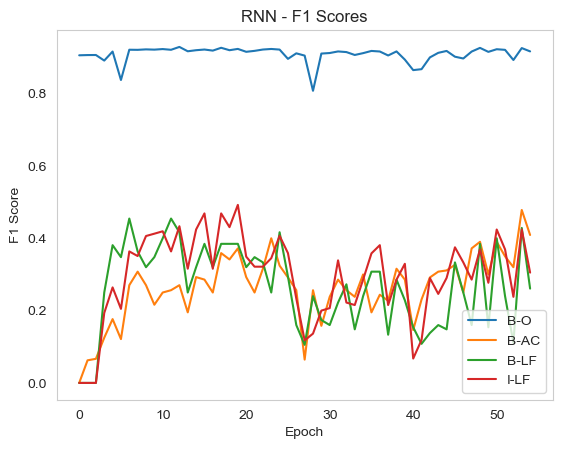

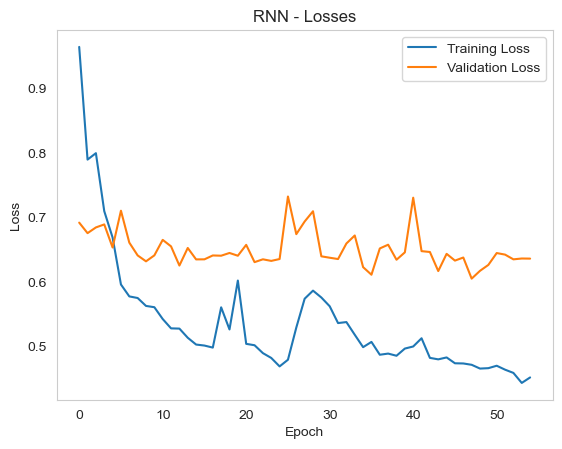

In [48]:
plot_metrics(model_file_path, 1, "RNN")

#### Experiment 1.2: LSTM Cells

In [176]:
# call build_model
model, model_config = build_model(
    input_dim=len(token_vocab),
    pos_dim=len(pos_tag_vocab),
    output_dim=len(ner_tag_vocab),
    emb_dim=100,
    hid_dim=256,
    n_layers=2,
    dropout=0.5,
    bidirectional=True,
    pretrained_embeddings=pretrained_embeddings,
    device=DEVICE,
    rnn_type="lstm"
)

# add vocab params to model_config
model_config["vocab_name"] = vocab_name
model_config["max_vocab_size"] = max_vocab_size
model_config["pretrained_emb"] = pretrained_emb
model_config["batch_size"] = batch_size

The model has 6,793,655 trainable parameters.


In [177]:
# define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=ner_tag_vocab["<pad>"])

In [178]:
if TRAIN:
    # train model
    model_file_path = train_loop(
        model=model,
        train_loader=train_data_loader,
        val_loader=val_data_loader,
        optimizer=optimizer,
        criterion=criterion,
        clip=1,
        teacher_forcing_ratio=0.5,
        device=DEVICE,
        n_epochs=55,
        model_config=model_config
    )
else:
    model_file_path = "output/model_20240410_184255.pt"

In [179]:
# model_file_path = "output/model_20240410_184255.pt"
# load best model
model = load_model_checkpoint(model, model_file_path)
# run test_model
test_model(model, test_data_loader, criterion, DEVICE)

Using model file: model_20240410_184255.pt, age: 9833.71 minutes
Test Loss: 0.3837
Accuracy: 0.8942
Overall F1: 0.8763


,precision,recall,f1,support
B-O,0.913876,0.979031,0.945332,4292
B-AC,0.764228,0.348148,0.478372,270
B-LF,0.375000,0.240000,0.292683,150
I-LF,0.673913,0.430556,0.525424,288


In [180]:
evaluate_seqeval(model, test_data_loader, DEVICE, ner_tag_vocab)

              precision    recall  f1-score   support

          AC       0.76      0.35      0.48       270
          LF       0.31      0.20      0.24       152
           O       0.91      0.98      0.95      4292

   micro avg       0.90      0.92      0.91      4714
   macro avg       0.66      0.51      0.55      4714
weighted avg       0.89      0.92      0.90      4714



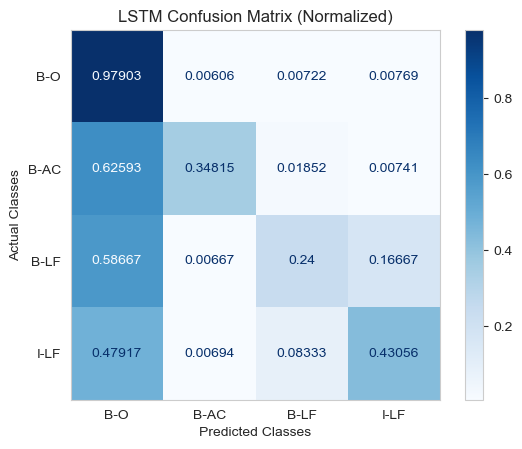

In [53]:
plot_cm(model, test_data_loader, DEVICE, 1, "LSTM")

{'input_dim': 9137,
 'pos_dim': 20,
 'output_dim': 7,
 'emb_dim': 100,
 'hid_dim': 256,
 'n_layers': 2,
 'dropout': 0.5,
 'bidirectional': True,
 'parameters': 6793655,
 'rnn_type': 'lstm',
 'vocab_name': None,
 'max_vocab_size': 25000,
 'pretrained_emb': False,
 'batch_size': 64,
 'n_epochs': 55,
 'clip': 1,
 'teacher_forcing_ratio': 0.5,
 'optimizer': 'Adam (\nParameter Group 0\n    amsgrad: False\n    betas: (0.9, 0.999)\n    eps: 1e-08\n    lr: 0.001\n    maximize: False\n    weight_decay: 0\n)',
 'loss_function': 'CrossEntropyLoss()',
 'class_labels': ['B-O', 'B-AC', 'B-LF', 'I-LF']}

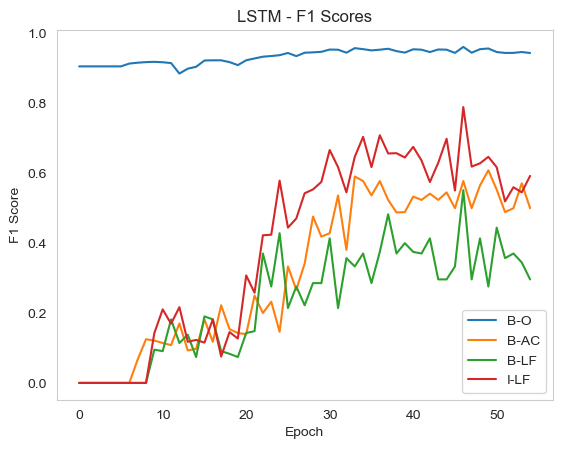

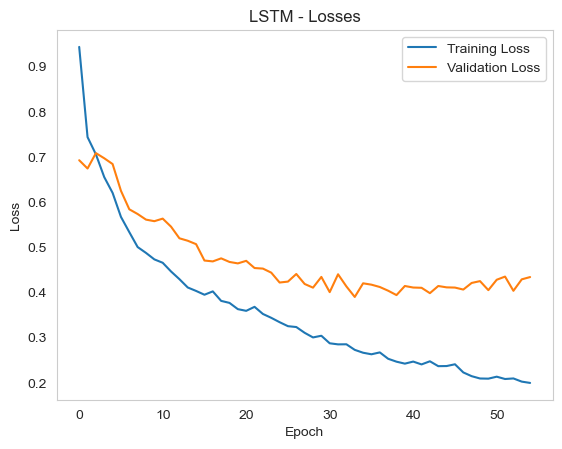

In [54]:
plot_metrics(model_file_path, 1, "LSTM")

#### Experiment 1.3: GRU Cells

In [181]:
# call build_model
model, model_config = build_model(
    input_dim=len(token_vocab),
    pos_dim=len(pos_tag_vocab),
    output_dim=len(ner_tag_vocab),
    emb_dim=100,
    hid_dim=256,
    n_layers=2,
    dropout=0.5,
    bidirectional=True,
    pretrained_embeddings=pretrained_embeddings,
    device=DEVICE,
    rnn_type="gru"
)

# add vocab params to model_config
model_config["vocab_name"] = vocab_name
model_config["max_vocab_size"] = max_vocab_size
model_config["pretrained_emb"] = pretrained_emb
model_config["batch_size"] = batch_size

The model has 5,325,239 trainable parameters.


In [182]:
# define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=ner_tag_vocab["<pad>"])

In [183]:
if TRAIN:
    # train model
    model_file_path = train_loop(
        model=model,
        train_loader=train_data_loader,
        val_loader=val_data_loader,
        optimizer=optimizer,
        criterion=criterion,
        clip=1,
        teacher_forcing_ratio=0.5,
        device=DEVICE,
        n_epochs=55,
        model_config=model_config
    )
else:
    model_file_path = "output/model_20240410_184633.pt"

In [184]:
# model_file_path = "output/model_20240410_184633.pt"
# load best model
model = load_model_checkpoint(model, model_file_path)
# run test_model
test_model(model, test_data_loader, criterion, DEVICE)

Using model file: model_20240410_184633.pt, age: 9830.20 minutes
Test Loss: 0.5020
Accuracy: 0.8591
Overall F1: 0.8479


,precision,recall,f1,support
B-O,0.884443,0.968313,0.924480,4292
B-AC,0.578947,0.244444,0.343750,270
B-LF,0.397590,0.220000,0.283262,150
I-LF,0.642857,0.375000,0.473684,288


In [185]:
evaluate_seqeval(model, test_data_loader, DEVICE, ner_tag_vocab)

              precision    recall  f1-score   support

          AC       0.58      0.24      0.34       270
          LF       0.31      0.17      0.22       152
           O       0.90      0.97      0.93      4292
        eos>       0.00      0.00      0.00         0

   micro avg       0.88      0.90      0.89      4714
   macro avg       0.45      0.35      0.37      4714
weighted avg       0.86      0.90      0.88      4714



C:\Users\evan9\anaconda3\envs\nlp2024\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: <eos> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


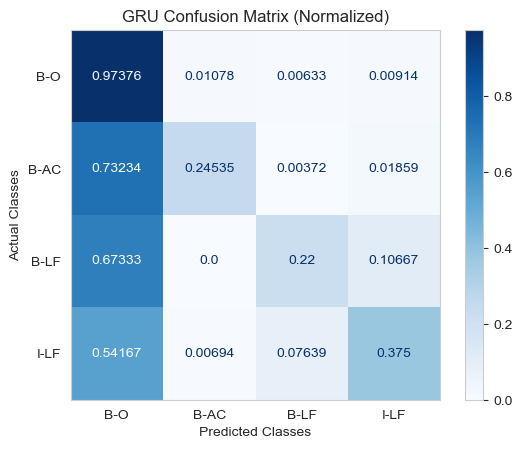

In [59]:
plot_cm(model, test_data_loader, DEVICE, 1, "GRU")

{'input_dim': 9137,
 'pos_dim': 20,
 'output_dim': 7,
 'emb_dim': 100,
 'hid_dim': 256,
 'n_layers': 2,
 'dropout': 0.5,
 'bidirectional': True,
 'parameters': 5325239,
 'rnn_type': 'gru',
 'vocab_name': None,
 'max_vocab_size': 25000,
 'pretrained_emb': False,
 'batch_size': 64,
 'n_epochs': 55,
 'clip': 1,
 'teacher_forcing_ratio': 0.5,
 'optimizer': 'Adam (\nParameter Group 0\n    amsgrad: False\n    betas: (0.9, 0.999)\n    eps: 1e-08\n    lr: 0.001\n    maximize: False\n    weight_decay: 0\n)',
 'loss_function': 'CrossEntropyLoss()',
 'class_labels': ['B-O', 'B-AC', 'B-LF', 'I-LF']}

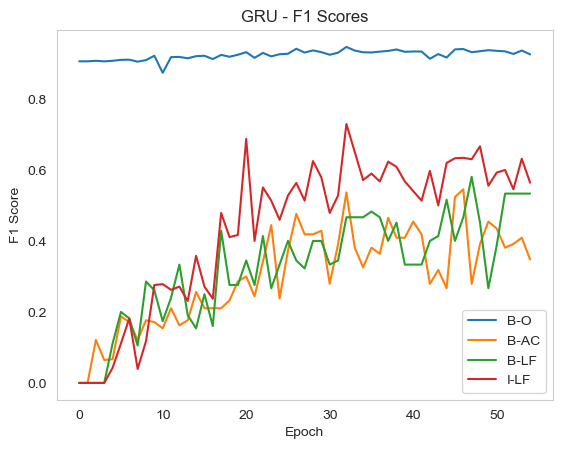

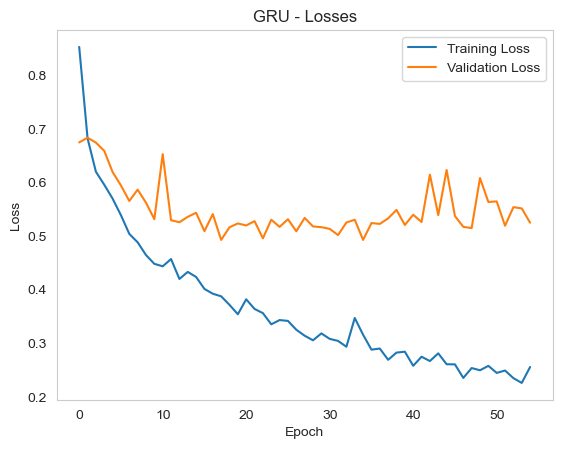

In [60]:
plot_metrics(model_file_path, 1, "GRU")

### Experiment 2

This experiment focuses on using various text encoding and embeddings techniques.
It will use the best performing model type from Experiment 1.

In [186]:
dataset = load_dataset("surrey-nlp/PLOD-CW")
train_data, val_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"]
)
pd.DataFrame(train_data[0]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,For,this,purpose,the,Gothenburg,Young,Persons,Empowerment,Scale,(,GYPES,),was,developed,.
pos_tags,ADP,DET,NOUN,DET,PROPN,PROPN,PROPN,PROPN,PROPN,PUNCT,PROPN,PUNCT,AUX,VERB,PUNCT
ner_tags,B-O,B-O,B-O,B-O,B-LF,I-LF,I-LF,I-LF,I-LF,B-O,B-AC,B-O,B-O,B-O,B-O


#### Experiment 2.1: GloVe Embeddings

In [187]:
# build data loaders
max_vocab_size = 25_000
vocab_name = "glove"
pretrained_emb = True
batch_size = 64

train_data_loader, val_data_loader, test_data_loader, pretrained_embeddings, token_vocab, ner_tag_vocab, pos_tag_vocab = get_data_loaders(max_vocab_size, vocab_name, pretrained_emb, train_data, val_data, test_data, batch_size) 

In [188]:
# call build_model
model, model_config = build_model(
    input_dim=len(token_vocab),
    pos_dim=len(pos_tag_vocab),
    output_dim=len(ner_tag_vocab),
    emb_dim=100,
    hid_dim=256,
    n_layers=2,
    dropout=0.5,
    bidirectional=True,
    pretrained_embeddings=pretrained_embeddings,
    device=DEVICE,
    rnn_type="lstm"
)

# add vocab params to model_config
model_config["vocab_name"] = vocab_name
model_config["max_vocab_size"] = max_vocab_size
model_config["pretrained_emb"] = pretrained_emb
model_config["batch_size"] = batch_size

The model has 5,879,255 trainable parameters.


In [189]:
# define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=ner_tag_vocab["<pad>"])

In [190]:
if TRAIN:
    # train model
    model_file_path = train_loop(
        model=model,
        train_loader=train_data_loader,
        val_loader=val_data_loader,
        optimizer=optimizer,
        criterion=criterion,
        clip=1,
        teacher_forcing_ratio=0.5,
        device=DEVICE,
        n_epochs=100,
        model_config=model_config
    )
else:
    model_file_path = "output/model_20240410_185021.pt"

In [191]:
# model_file_path = "output/model_20240410_185021.pt"
# load best model
model = load_model_checkpoint(model, model_file_path)
# run test_model
test_model(model, test_data_loader, criterion, DEVICE)

Using model file: model_20240410_185021.pt, age: 9826.68 minutes
Test Loss: 0.2898
Accuracy: 0.9158
Overall F1: 0.9099


,precision,recall,f1,support
B-O,0.946014,0.967614,0.956692,4292
B-AC,0.751131,0.614815,0.676171,270
B-LF,0.480315,0.406667,0.440433,150
I-LF,0.709924,0.645833,0.676364,288


In [192]:
evaluate_seqeval(model, test_data_loader, DEVICE, ner_tag_vocab)

              precision    recall  f1-score   support

          AC       0.75      0.61      0.68       270
          LF       0.40      0.34      0.37       152
           O       0.95      0.97      0.96      4292

   micro avg       0.92      0.93      0.92      4714
   macro avg       0.70      0.64      0.67      4714
weighted avg       0.92      0.93      0.92      4714



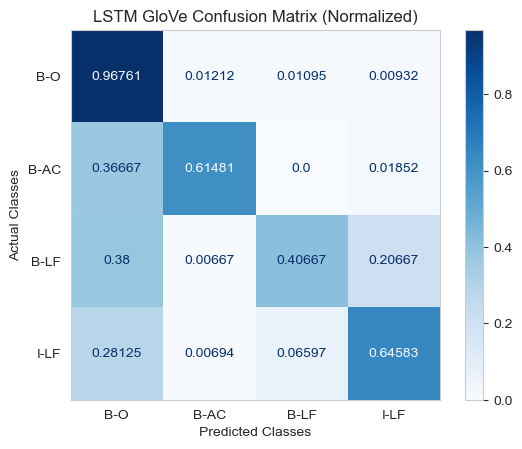

In [67]:
plot_cm(model, test_data_loader, DEVICE, 2, "LSTM GloVe")

{'input_dim': 25004,
 'pos_dim': 20,
 'output_dim': 7,
 'emb_dim': 100,
 'hid_dim': 256,
 'n_layers': 2,
 'dropout': 0.5,
 'bidirectional': True,
 'parameters': 5879255,
 'rnn_type': 'lstm',
 'vocab_name': 'glove',
 'max_vocab_size': 25000,
 'pretrained_emb': True,
 'batch_size': 64,
 'n_epochs': 100,
 'clip': 1,
 'teacher_forcing_ratio': 0.5,
 'optimizer': 'Adam (\nParameter Group 0\n    amsgrad: False\n    betas: (0.9, 0.999)\n    eps: 1e-08\n    lr: 0.001\n    maximize: False\n    weight_decay: 0\n)',
 'loss_function': 'CrossEntropyLoss()',
 'class_labels': ['B-O', 'B-AC', 'B-LF', 'I-LF']}

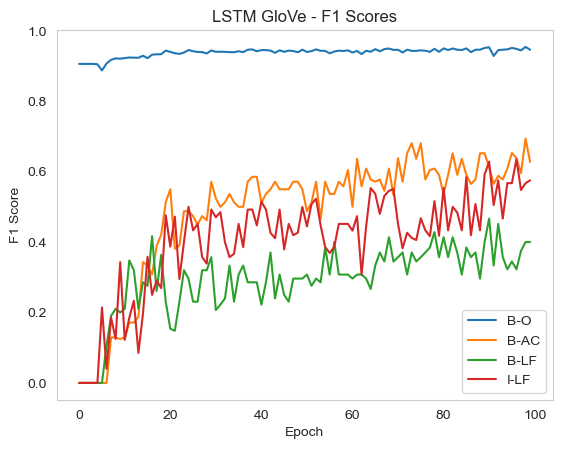

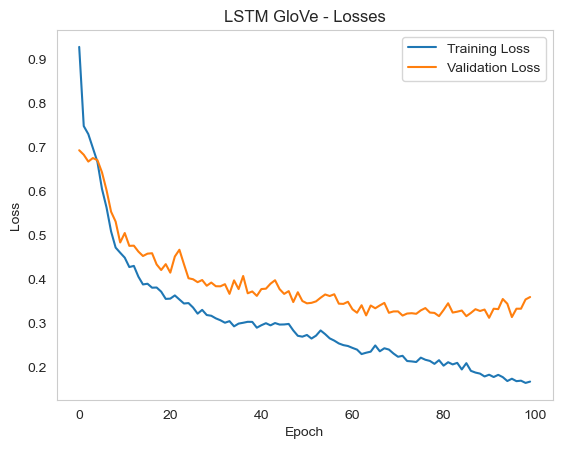

In [68]:
plot_metrics(model_file_path, 2, "LSTM GloVe")

#### Experiment 2.2: FastText Embeddings

In [193]:
# build data loaders
max_vocab_size = 25_000
vocab_name = "fasttext"
pretrained_emb = True
batch_size = 64

train_data_loader, val_data_loader, test_data_loader, pretrained_embeddings, token_vocab, ner_tag_vocab, pos_tag_vocab = get_data_loaders(max_vocab_size, vocab_name, pretrained_emb, train_data, val_data, test_data, batch_size)

In [194]:
# call build_model
model, model_config = build_model(
    input_dim=len(token_vocab),
    pos_dim=len(pos_tag_vocab),
    output_dim=len(ner_tag_vocab),
    emb_dim=300,
    hid_dim=256,
    n_layers=2,
    dropout=0.5,
    bidirectional=True,
    pretrained_embeddings=pretrained_embeddings,
    device=DEVICE,
    rnn_type="lstm"
)

# add vocab params to model_config
model_config["vocab_name"] = vocab_name
model_config["max_vocab_size"] = max_vocab_size
model_config["pretrained_emb"] = pretrained_emb
model_config["batch_size"] = batch_size

The model has 7,112,055 trainable parameters.


In [195]:
# define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=ner_tag_vocab["<pad>"])

In [196]:
if TRAIN:
    # train model
    model_file_path = train_loop(
        model=model,
        train_loader=train_data_loader,
        val_loader=val_data_loader,
        optimizer=optimizer,
        criterion=criterion,
        clip=1,
        teacher_forcing_ratio=0.5,
        device=DEVICE,
        n_epochs=100,
        model_config=model_config
    )
else:
    model_file_path = "output/model_20240410_185658.pt"

In [197]:
# model_file_path = "output/model_20240410_185658.pt"
# load best model
model = load_model_checkpoint(model, model_file_path)
# run test_model
test_model(model, test_data_loader, criterion, DEVICE)

Using model file: model_20240410_185658.pt, age: 9820.37 minutes
Test Loss: 0.2805
Accuracy: 0.9092
Overall F1: 0.9038


,precision,recall,f1,support
B-O,0.943439,0.959925,0.951611,4292
B-AC,0.802198,0.540741,0.646018,270
B-LF,0.564516,0.466667,0.510949,150
I-LF,0.599388,0.680556,0.637398,288


In [198]:
evaluate_seqeval(model, test_data_loader, DEVICE, ner_tag_vocab)

              precision    recall  f1-score   support

          AC       0.80      0.54      0.65       270
          LF       0.48      0.39      0.43       152
           O       0.94      0.96      0.95      4292

   micro avg       0.93      0.92      0.92      4714
   macro avg       0.74      0.63      0.68      4714
weighted avg       0.92      0.92      0.92      4714



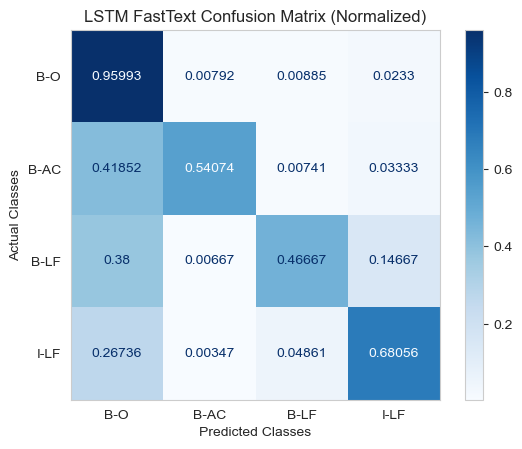

In [74]:
plot_cm(model, test_data_loader, DEVICE, 2, "LSTM FastText")

{'input_dim': 25004,
 'pos_dim': 20,
 'output_dim': 7,
 'emb_dim': 300,
 'hid_dim': 256,
 'n_layers': 2,
 'dropout': 0.5,
 'bidirectional': True,
 'parameters': 7112055,
 'rnn_type': 'lstm',
 'vocab_name': 'fasttext',
 'max_vocab_size': 25000,
 'pretrained_emb': True,
 'batch_size': 64,
 'n_epochs': 100,
 'clip': 1,
 'teacher_forcing_ratio': 0.5,
 'optimizer': 'Adam (\nParameter Group 0\n    amsgrad: False\n    betas: (0.9, 0.999)\n    eps: 1e-08\n    lr: 0.001\n    maximize: False\n    weight_decay: 0\n)',
 'loss_function': 'CrossEntropyLoss()',
 'class_labels': ['B-O', 'B-AC', 'B-LF', 'I-LF']}

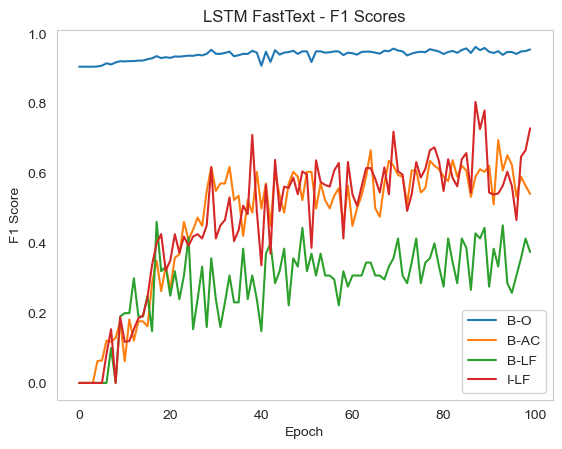

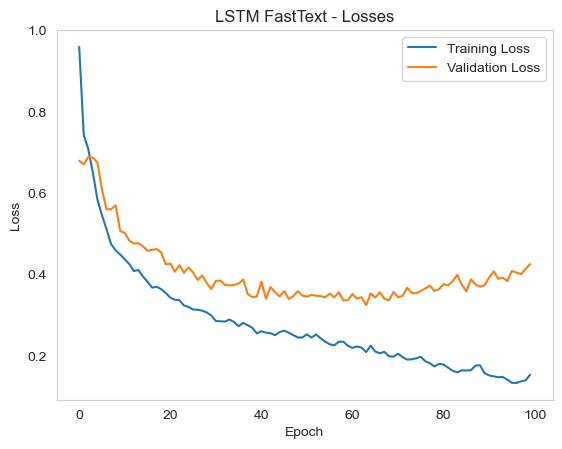

In [75]:
plot_metrics(model_file_path, 2, "LSTM FastText")

#### Experiment 2.3: word2vec Embeddings

In [199]:
# build data loaders
max_vocab_size = 25_000
vocab_name = "word2vec"
pretrained_emb = True
batch_size = 64

train_data_loader, val_data_loader, test_data_loader, pretrained_embeddings, token_vocab, ner_tag_vocab, pos_tag_vocab = get_data_loaders(max_vocab_size, vocab_name, pretrained_emb, train_data, val_data, test_data, batch_size)

In [200]:
# call build_model
model, model_config = build_model(
    input_dim=len(token_vocab),
    pos_dim=len(pos_tag_vocab),
    output_dim=len(ner_tag_vocab),
    emb_dim=300,
    hid_dim=256,
    n_layers=2,
    dropout=0.5,
    bidirectional=True,
    pretrained_embeddings=pretrained_embeddings,
    device=DEVICE,
    rnn_type="lstm"
)

# add vocab params to model_config
model_config["vocab_name"] = vocab_name
model_config["max_vocab_size"] = max_vocab_size
model_config["pretrained_emb"] = pretrained_emb
model_config["batch_size"] = batch_size

The model has 7,112,055 trainable parameters.


In [201]:
# define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=ner_tag_vocab["<pad>"])

In [202]:
if TRAIN:
    # train model
    model_file_path = train_loop(
        model=model,
        train_loader=train_data_loader,
        val_loader=val_data_loader,
        optimizer=optimizer,
        criterion=criterion,
        clip=1,
        teacher_forcing_ratio=0.5,
        device=DEVICE,
        n_epochs=100,
        model_config=model_config
    )
else:
    model_file_path = "output/model_20240410_190349.pt"

In [203]:
# model_file_path = "output/model_20240410_190349.pt"
# load best model
model = load_model_checkpoint(model, model_file_path)
# run test_model
test_model(model, test_data_loader, criterion, DEVICE)

Using model file: model_20240410_190349.pt, age: 9814.03 minutes
Test Loss: 0.3193
Accuracy: 0.9003
Overall F1: 0.8882


,precision,recall,f1,support
B-O,0.924373,0.971109,0.947165,4292
B-AC,0.775862,0.500000,0.608108,270
B-LF,0.436893,0.300000,0.355731,150
I-LF,0.644860,0.479167,0.549801,288


In [204]:
evaluate_seqeval(model, test_data_loader, DEVICE, ner_tag_vocab)

              precision    recall  f1-score   support

          AC       0.78      0.50      0.61       270
          LF       0.36      0.26      0.30       152
           O       0.92      0.97      0.95      4292

   micro avg       0.91      0.92      0.91      4714
   macro avg       0.69      0.58      0.62      4714
weighted avg       0.90      0.92      0.91      4714



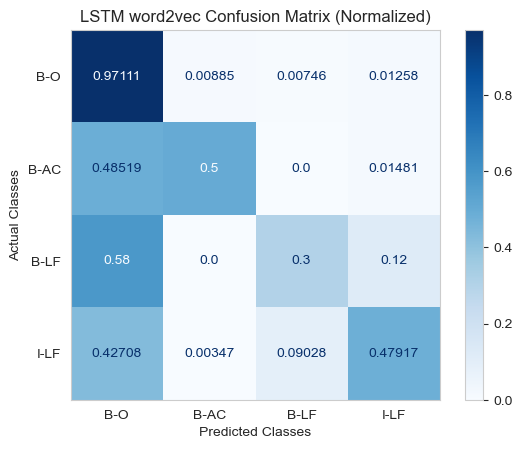

In [81]:
plot_cm(model, test_data_loader, DEVICE, 2, "LSTM word2vec")

{'input_dim': 25004,
 'pos_dim': 20,
 'output_dim': 7,
 'emb_dim': 300,
 'hid_dim': 256,
 'n_layers': 2,
 'dropout': 0.5,
 'bidirectional': True,
 'parameters': 7112055,
 'rnn_type': 'lstm',
 'vocab_name': 'word2vec',
 'max_vocab_size': 25000,
 'pretrained_emb': True,
 'batch_size': 64,
 'n_epochs': 100,
 'clip': 1,
 'teacher_forcing_ratio': 0.5,
 'optimizer': 'Adam (\nParameter Group 0\n    amsgrad: False\n    betas: (0.9, 0.999)\n    eps: 1e-08\n    lr: 0.001\n    maximize: False\n    weight_decay: 0\n)',
 'loss_function': 'CrossEntropyLoss()',
 'class_labels': ['B-O', 'B-AC', 'B-LF', 'I-LF']}

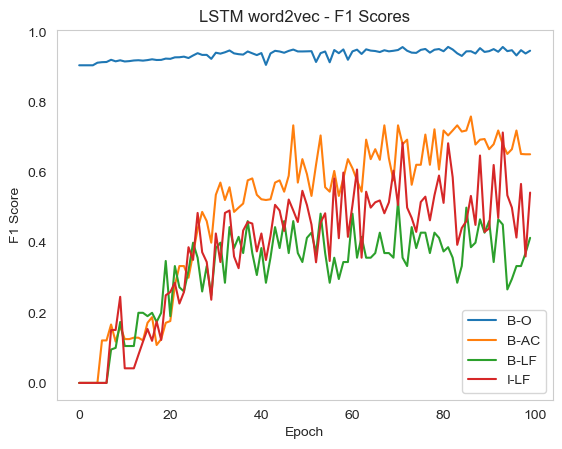

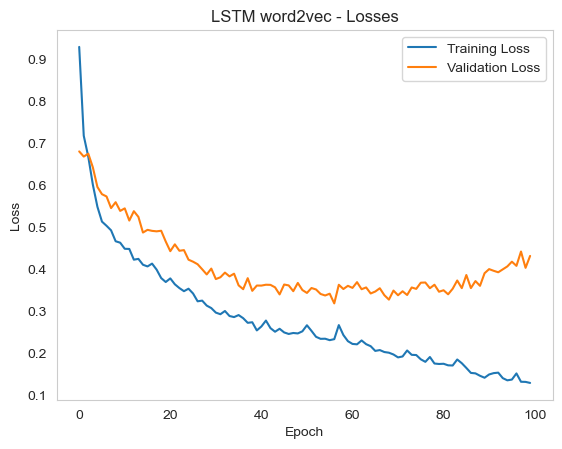

In [82]:
plot_metrics(model_file_path, 2, "LSTM word2vec")

### Experiment 3

This experiment focuses on using different optimization algorithms.

It will use the best performing model type and embedding technique from Experiment 2.

In [205]:
dataset = load_dataset("surrey-nlp/PLOD-CW")
train_data, val_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"]
)
pd.DataFrame(train_data[0]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,For,this,purpose,the,Gothenburg,Young,Persons,Empowerment,Scale,(,GYPES,),was,developed,.
pos_tags,ADP,DET,NOUN,DET,PROPN,PROPN,PROPN,PROPN,PROPN,PUNCT,PROPN,PUNCT,AUX,VERB,PUNCT
ner_tags,B-O,B-O,B-O,B-O,B-LF,I-LF,I-LF,I-LF,I-LF,B-O,B-AC,B-O,B-O,B-O,B-O


In [206]:
# build data loaders
max_vocab_size = 25_000
vocab_name = "glove"
pretrained_emb = True
batch_size = 64

train_data_loader, val_data_loader, test_data_loader, pretrained_embeddings, token_vocab, ner_tag_vocab, pos_tag_vocab = get_data_loaders(max_vocab_size, vocab_name, pretrained_emb, train_data, val_data, test_data, batch_size)

#### Experiment 3.1: Adam Optimizer

In [207]:
# call build_model
model, model_config = build_model(
    input_dim=len(token_vocab),
    pos_dim=len(pos_tag_vocab),
    output_dim=len(ner_tag_vocab),
    emb_dim=100,
    hid_dim=256,
    n_layers=2,
    dropout=0.5,
    bidirectional=True,
    pretrained_embeddings=pretrained_embeddings,
    device=DEVICE,
    rnn_type="lstm"
)

# add vocab params to model_config
model_config["vocab_name"] = vocab_name
model_config["max_vocab_size"] = max_vocab_size
model_config["pretrained_emb"] = pretrained_emb
model_config["batch_size"] = batch_size

The model has 5,879,255 trainable parameters.


In [208]:
# define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=ner_tag_vocab["<pad>"])

In [209]:
if TRAIN:
    # train model
    model_file_path = train_loop(
        model=model,
        train_loader=train_data_loader,
        val_loader=val_data_loader,
        optimizer=optimizer,
        criterion=criterion,
        clip=1,
        teacher_forcing_ratio=0.5,
        device=DEVICE,
        n_epochs=100,
        model_config=model_config
    )
else:
    model_file_path = "output/model_20240410_191116.pt"

In [211]:
# model_file_path = "output/model_20240410_191116.pt"
# load best model
model = load_model_checkpoint(model, model_file_path)
# run test_model
test_model(model, test_data_loader, criterion, DEVICE)

Using model file: model_20240410_191116.pt, age: 9807.00 minutes
Test Loss: 0.3116
Accuracy: 0.9117
Overall F1: 0.9052


,precision,recall,f1,support
B-O,0.941871,0.966449,0.954002,4292
B-AC,0.788360,0.551852,0.649237,270
B-LF,0.511811,0.433333,0.469314,150
I-LF,0.653571,0.635417,0.644366,288


In [212]:
evaluate_seqeval(model, test_data_loader, DEVICE, ner_tag_vocab)

              precision    recall  f1-score   support

          AC       0.79      0.55      0.65       270
          LF       0.43      0.36      0.39       152
           O       0.94      0.97      0.95      4292

   micro avg       0.92      0.92      0.92      4714
   macro avg       0.72      0.63      0.67      4714
weighted avg       0.92      0.92      0.92      4714



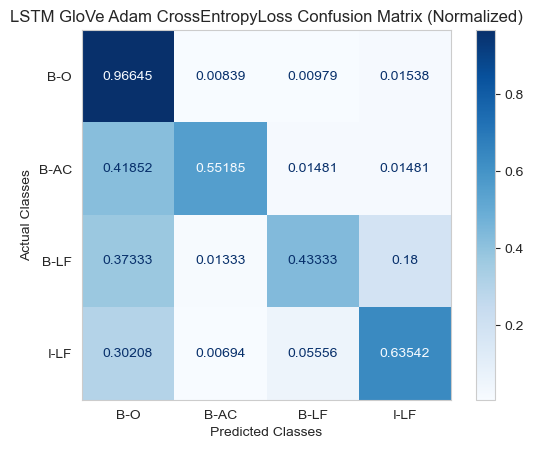

In [89]:
plot_cm(model, test_data_loader, DEVICE, 3, "LSTM GloVe Adam CrossEntropyLoss")

{'input_dim': 25004,
 'pos_dim': 20,
 'output_dim': 7,
 'emb_dim': 100,
 'hid_dim': 256,
 'n_layers': 2,
 'dropout': 0.5,
 'bidirectional': True,
 'parameters': 5879255,
 'rnn_type': 'lstm',
 'vocab_name': 'glove',
 'max_vocab_size': 25000,
 'pretrained_emb': True,
 'batch_size': 64,
 'n_epochs': 100,
 'clip': 1,
 'teacher_forcing_ratio': 0.5,
 'optimizer': 'Adam (\nParameter Group 0\n    amsgrad: False\n    betas: (0.9, 0.999)\n    eps: 1e-08\n    lr: 0.001\n    maximize: False\n    weight_decay: 0\n)',
 'loss_function': 'CrossEntropyLoss()',
 'class_labels': ['B-O', 'B-AC', 'B-LF', 'I-LF']}

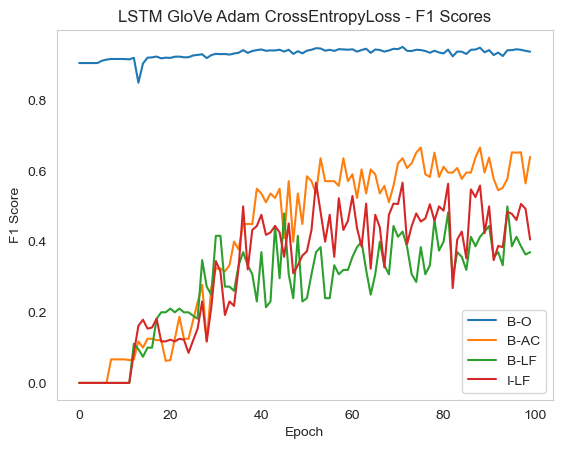

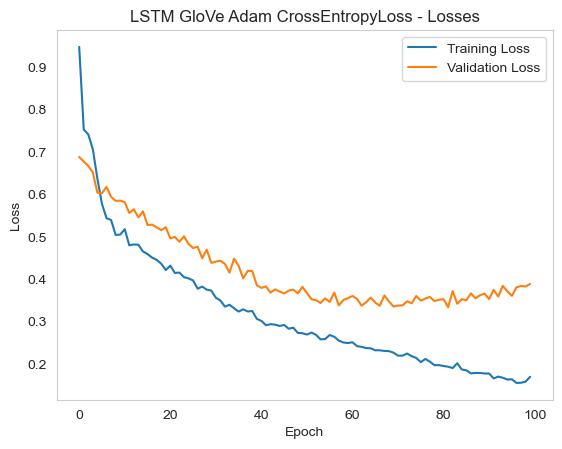

In [90]:
plot_metrics(model_file_path, 3, "LSTM GloVe Adam CrossEntropyLoss")

#### Experiment 3.2: AdamW 

In [213]:
# call build_model
model, model_config = build_model(
    input_dim=len(token_vocab),
    pos_dim=len(pos_tag_vocab),
    output_dim=len(ner_tag_vocab),
    emb_dim=100,
    hid_dim=256,
    n_layers=2,
    dropout=0.5,
    bidirectional=True,
    pretrained_embeddings=pretrained_embeddings,
    device=DEVICE,
    rnn_type="lstm"
)

# add vocab params to model_config
model_config["vocab_name"] = vocab_name
model_config["max_vocab_size"] = max_vocab_size
model_config["pretrained_emb"] = pretrained_emb
model_config["batch_size"] = batch_size

The model has 5,879,255 trainable parameters.


In [214]:
# define optimizer and loss function
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=ner_tag_vocab["<pad>"])

In [215]:
if TRAIN:
    # train model
    model_file_path = train_loop(
        model=model,
        train_loader=train_data_loader,
        val_loader=val_data_loader,
        optimizer=optimizer,
        criterion=criterion,
        clip=1,
        teacher_forcing_ratio=0.5,
        device=DEVICE,
        n_epochs=100,
        model_config=model_config
    )
else:
    model_file_path = "output/model_20240410_191816.pt"

In [216]:
# model_file_path = "output/model_20240410_191816.pt"
# load best model
model = load_model_checkpoint(model, model_file_path)
# run test_model
test_model(model, test_data_loader, criterion, DEVICE)

Using model file: model_20240410_191816.pt, age: 9800.22 minutes
Test Loss: 0.2843
Accuracy: 0.9109
Overall F1: 0.9042


,precision,recall,f1,support
B-O,0.942032,0.965517,0.953630,4292
B-AC,0.794760,0.674074,0.729459,270
B-LF,0.456897,0.353333,0.398496,150
I-LF,0.632812,0.562500,0.595588,288


In [217]:
evaluate_seqeval(model, test_data_loader, DEVICE, ner_tag_vocab)

              precision    recall  f1-score   support

          AC       0.79      0.67      0.73       270
          LF       0.36      0.28      0.31       152
           O       0.94      0.97      0.95      4292

   micro avg       0.92      0.93      0.92      4714
   macro avg       0.70      0.64      0.67      4714
weighted avg       0.91      0.93      0.92      4714



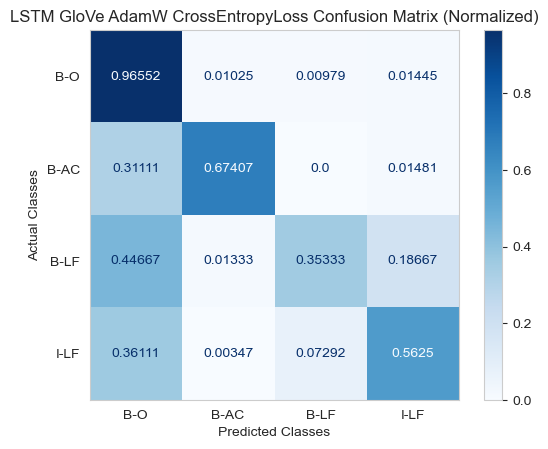

In [95]:
plot_cm(model, test_data_loader, DEVICE, 3, "LSTM GloVe AdamW CrossEntropyLoss")

{'input_dim': 25004,
 'pos_dim': 20,
 'output_dim': 7,
 'emb_dim': 100,
 'hid_dim': 256,
 'n_layers': 2,
 'dropout': 0.5,
 'bidirectional': True,
 'parameters': 5879255,
 'rnn_type': 'lstm',
 'vocab_name': 'glove',
 'max_vocab_size': 25000,
 'pretrained_emb': True,
 'batch_size': 64,
 'n_epochs': 100,
 'clip': 1,
 'teacher_forcing_ratio': 0.5,
 'optimizer': 'AdamW (\nParameter Group 0\n    amsgrad: False\n    betas: (0.9, 0.999)\n    eps: 1e-08\n    lr: 0.001\n    maximize: False\n    weight_decay: 0.01\n)',
 'loss_function': 'CrossEntropyLoss()',
 'class_labels': ['B-O', 'B-AC', 'B-LF', 'I-LF']}

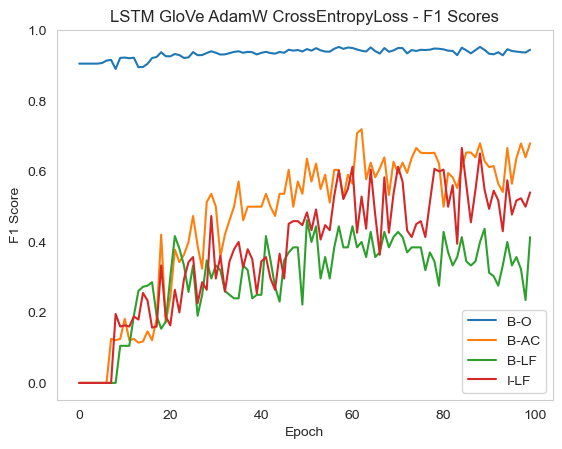

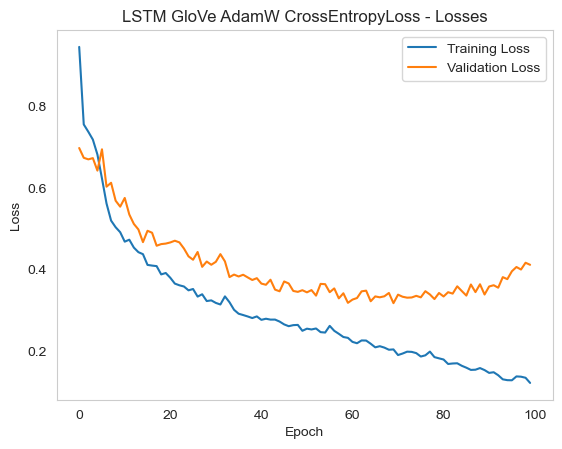

In [96]:
plot_metrics(model_file_path, 3, "LSTM GloVe AdamW CrossEntropyLoss")

#### Experiment 3.3: Adagrad Optimizer

In [218]:
# call build_model
model, model_config = build_model(
    input_dim=len(token_vocab),
    pos_dim=len(pos_tag_vocab),
    output_dim=len(ner_tag_vocab),
    emb_dim=100,
    hid_dim=256,
    n_layers=2,
    dropout=0.5,
    bidirectional=True,
    pretrained_embeddings=pretrained_embeddings,
    device=DEVICE,
    rnn_type="lstm"
)

# add vocab params to model_config
model_config["vocab_name"] = vocab_name
model_config["max_vocab_size"] = max_vocab_size
model_config["pretrained_emb"] = pretrained_emb
model_config["batch_size"] = batch_size 

The model has 5,879,255 trainable parameters.


In [219]:
# define optimizer and loss function
optimizer = optim.Adagrad(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=ner_tag_vocab["<pad>"])

In [220]:
if TRAIN:
    # train model
    model_file_path = train_loop(
        model=model,
        train_loader=train_data_loader,
        val_loader=val_data_loader,
        optimizer=optimizer,
        criterion=criterion,
        clip=1,
        teacher_forcing_ratio=0.5,
        device=DEVICE,
        n_epochs=100,
        model_config=model_config
    )
else:
    model_file_path = "output/model_20240410_192519.pt"

In [221]:
# model_file_path = "output/model_20240410_192519.pt"
# load best model
model = load_model_checkpoint(model, model_file_path)
# run test_model
test_model(model, test_data_loader, criterion, DEVICE)

Using model file: model_20240410_192519.pt, age: 9793.45 minutes
Test Loss: 0.3030
Accuracy: 0.9047
Overall F1: 0.8959


,precision,recall,f1,support
B-O,0.934787,0.968546,0.951367,4292
B-AC,0.730964,0.533333,0.616702,270
B-LF,0.427350,0.333333,0.374532,150
I-LF,0.662500,0.552083,0.602273,288


In [222]:
evaluate_seqeval(model, test_data_loader, DEVICE, ner_tag_vocab)

              precision    recall  f1-score   support

          AC       0.73      0.53      0.62       270
          LF       0.31      0.24      0.27       152
           O       0.93      0.97      0.95      4292

   micro avg       0.91      0.92      0.92      4714
   macro avg       0.66      0.58      0.61      4714
weighted avg       0.90      0.92      0.91      4714



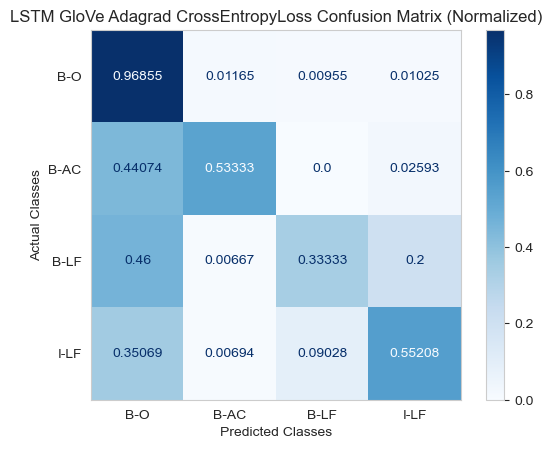

In [101]:
plot_cm(model, test_data_loader, DEVICE, 3, "LSTM GloVe Adagrad CrossEntropyLoss")

{'input_dim': 25004,
 'pos_dim': 20,
 'output_dim': 7,
 'emb_dim': 100,
 'hid_dim': 256,
 'n_layers': 2,
 'dropout': 0.5,
 'bidirectional': True,
 'parameters': 5879255,
 'rnn_type': 'lstm',
 'vocab_name': 'glove',
 'max_vocab_size': 25000,
 'pretrained_emb': True,
 'batch_size': 64,
 'n_epochs': 100,
 'clip': 1,
 'teacher_forcing_ratio': 0.5,
 'optimizer': 'Adagrad (\nParameter Group 0\n    eps: 1e-10\n    initial_accumulator_value: 0\n    lr: 0.01\n    lr_decay: 0\n    weight_decay: 0\n)',
 'loss_function': 'CrossEntropyLoss()',
 'class_labels': ['B-O', 'B-AC', 'B-LF', 'I-LF']}

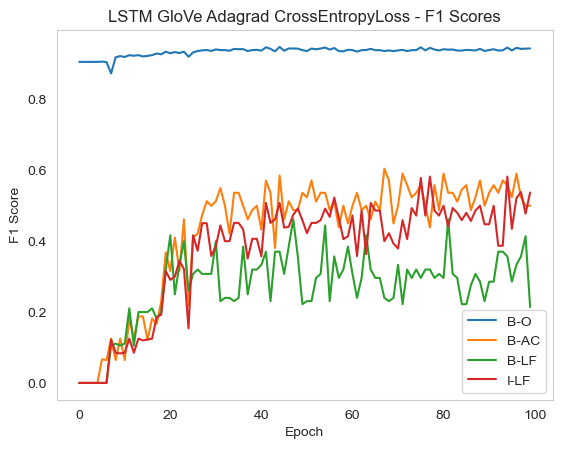

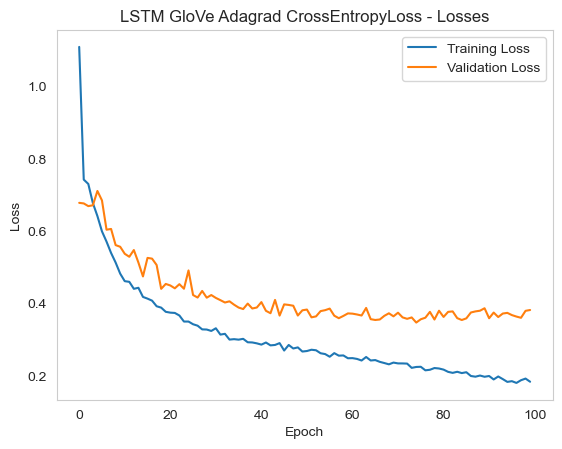

In [102]:
plot_metrics(model_file_path, 3, "LSTM GloVe Adagrad CrossEntropyLoss")

#### Experiment 3.4: Focal Loss

In [223]:
# call build_model
model, model_config = build_model(
    input_dim=len(token_vocab),
    pos_dim=len(pos_tag_vocab),
    output_dim=len(ner_tag_vocab),
    emb_dim=100,
    hid_dim=256,
    n_layers=2,
    dropout=0.5,
    bidirectional=True,
    pretrained_embeddings=pretrained_embeddings,
    device=DEVICE,
    rnn_type="lstm"
)

# add vocab params to model_config
model_config["vocab_name"] = vocab_name
model_config["max_vocab_size"] = max_vocab_size
model_config["pretrained_emb"] = pretrained_emb
model_config["batch_size"] = batch_size

The model has 5,879,255 trainable parameters.


In [224]:
# define optimizer and loss function
optimizer = optim.Adam(model.parameters())
# focal loss function: https://arxiv.org/abs/1708.02002v2
def focal_loss(y_pred, y_true, alpha=0.25, gamma=2):
    ce_loss = nn.CrossEntropyLoss(reduction='none')(y_pred, y_true)
    pt = torch.exp(-ce_loss)
    focal_loss = alpha * (1-pt)**gamma * ce_loss
    return focal_loss.mean()
criterion = focal_loss

In [225]:
if TRAIN:
    # train model
    model_file_path = train_loop(
        model=model,
        train_loader=train_data_loader,
        val_loader=val_data_loader,
        optimizer=optimizer,
        criterion=criterion,
        clip=1,
        teacher_forcing_ratio=0.5,
        device=DEVICE,
        n_epochs=100,
        model_config=model_config
    )
else:
    model_file_path = "output/model_20240410_193137.pt"

In [226]:
# model_file_path = "output/model_20240410_193137.pt"
# load best model
model = load_model_checkpoint(model, model_file_path)
# run test_model
test_model(model, test_data_loader, criterion, DEVICE)

Using model file: model_20240410_193137.pt, age: 9787.38 minutes
Test Loss: 0.0167
Accuracy: 0.9006
Overall F1: 0.8927


,precision,recall,f1,support
B-O,0.934783,0.961789,0.948094,4292
B-AC,0.701357,0.574074,0.631365,270
B-LF,0.436975,0.346667,0.386617,150
I-LF,0.627049,0.531250,0.575188,288


In [227]:
evaluate_seqeval(model, test_data_loader, DEVICE, ner_tag_vocab)

              precision    recall  f1-score   support

          AC       0.70      0.57      0.63       270
          LF       0.35      0.28      0.31       152
           O       0.93      0.96      0.95      4292

   micro avg       0.91      0.92      0.91      4714
   macro avg       0.66      0.61      0.63      4714
weighted avg       0.90      0.92      0.91      4714



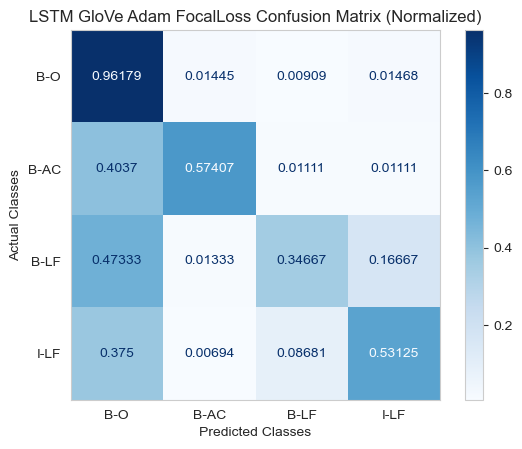

In [107]:
plot_cm(model, test_data_loader, DEVICE, 3, "LSTM GloVe Adam FocalLoss")

{'input_dim': 25004,
 'pos_dim': 20,
 'output_dim': 7,
 'emb_dim': 100,
 'hid_dim': 256,
 'n_layers': 2,
 'dropout': 0.5,
 'bidirectional': True,
 'parameters': 5879255,
 'rnn_type': 'lstm',
 'vocab_name': 'glove',
 'max_vocab_size': 25000,
 'pretrained_emb': True,
 'batch_size': 64,
 'n_epochs': 100,
 'clip': 1,
 'teacher_forcing_ratio': 0.5,
 'optimizer': 'Adam (\nParameter Group 0\n    amsgrad: False\n    betas: (0.9, 0.999)\n    eps: 1e-08\n    lr: 0.001\n    maximize: False\n    weight_decay: 0\n)',
 'loss_function': '<function focal_loss at 0x000001C781E5F820>',
 'class_labels': ['B-O', 'B-AC', 'B-LF', 'I-LF']}

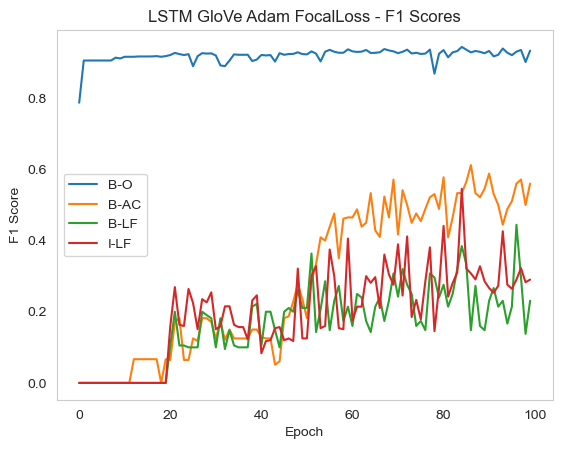

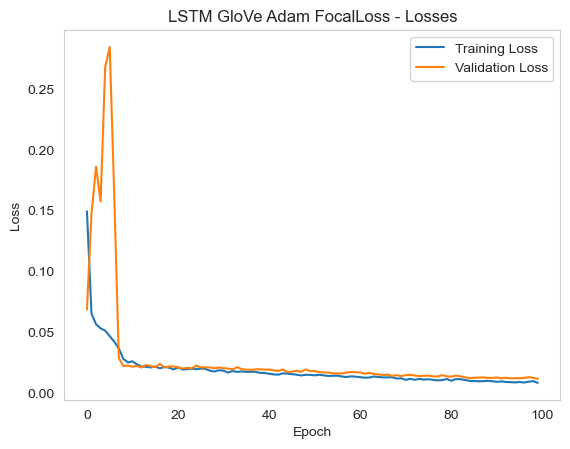

In [108]:
plot_metrics(model_file_path, 3, "LSTM GloVe Adam FocalLoss")

### Experiment 4

This experiment focuses on using different hyperparameters for the model.

In [32]:
dataset = load_dataset("surrey-nlp/PLOD-CW")
train_data, val_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"]
)

#### Experiment 4.1: Random Search

In [35]:
def train_tune(config):
    # build data loaders
    max_vocab_size = 25_000
    vocab_name = "glove"
    pretrained_emb = True
    batch_size = 16

    train_data_loader, val_data_loader, test_data_loader, pretrained_embeddings, token_vocab, ner_tag_vocab, pos_tag_vocab = get_data_loaders(max_vocab_size, vocab_name, pretrained_emb, train_data, val_data, test_data, batch_size)

    model, model_config = build_model(
        input_dim=len(token_vocab),
        pos_dim=len(pos_tag_vocab),
        output_dim=len(ner_tag_vocab),
        emb_dim=100,
        hid_dim=config["hid_dim"],
        n_layers=config["n_layers"],
        dropout=config["dropout"],
        bidirectional=True,
        pretrained_embeddings=pretrained_embeddings,
        device=DEVICE,
        rnn_type="lstm",
    )

    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    criterion = nn.CrossEntropyLoss(ignore_index=ner_tag_vocab["<pad>"])

    # train model
    model_file_path = train_loop(
        model=model,
        train_loader=train_data_loader,
        val_loader=val_data_loader,
        optimizer=optimizer,
        criterion=criterion,
        clip=1,
        teacher_forcing_ratio=0.5,
        device=DEVICE,
        n_epochs=100,
        model_config=model_config,
        output_directory="output/grid_search"
    )

    # load best model
    model = load_model_checkpoint(model, model_file_path)
    # run test_model
    test_model(model, test_data_loader, criterion, DEVICE)

    macro_f1 = evaluate_seqeval(model, test_data_loader, DEVICE, ner_tag_vocab, return_macro_average=True)

    return macro_f1, model_file_path

In [36]:
config = {
    "lr": {
        "type": "loguniform",
        "low": 1e-5,
        "high": 1e-1
    },
    "hid_dim": {
        "type": "choice",
        "values": [128, 256, 512]
    },
    "n_layers": {
        "type": "choice",
        "values": [2, 4]
    },
    "dropout": {
        "type": "uniform",
        "low": 0.1,
        "high": 0.9
    },
    "teacher_forcing_ratio": {
        "type": "uniform",
        "low": 0.1,
        "high": 0.9
    }
}

# sample 15 random configurations
configurations = []
for i in range(15):
    config_sample = {}
    while True:
        for key, value in config.items():
            if value["type"] == "loguniform":
                config_sample[key] = round(scipy.stats.loguniform.rvs(value["low"], value["high"]), 5)
            elif value["type"] == "choice":
                config_sample[key] = random.choice(value["values"])
            elif value["type"] == "uniform":
                config_sample[key] = round(np.random.uniform(value["low"], value["high"]), 3)

        # generate new config if hid_dim is 512 and n_layers is 4 as oom error occurs
        if config_sample["hid_dim"] == 512 and config_sample["n_layers"] == 4:
            continue
        else:
            break

    configurations.append(config_sample)

print(*configurations, sep="\n")

{'lr': 6e-05, 'hid_dim': 256, 'n_layers': 2, 'dropout': 0.598, 'teacher_forcing_ratio': 0.45}
{'lr': 0.01385, 'hid_dim': 128, 'n_layers': 2, 'dropout': 0.724, 'teacher_forcing_ratio': 0.318}
{'lr': 0.00013, 'hid_dim': 512, 'n_layers': 2, 'dropout': 0.741, 'teacher_forcing_ratio': 0.867}
{'lr': 0.0319, 'hid_dim': 512, 'n_layers': 2, 'dropout': 0.386, 'teacher_forcing_ratio': 0.501}
{'lr': 0.00542, 'hid_dim': 128, 'n_layers': 4, 'dropout': 0.67, 'teacher_forcing_ratio': 0.396}
{'lr': 0.00176, 'hid_dim': 128, 'n_layers': 2, 'dropout': 0.502, 'teacher_forcing_ratio': 0.111}
{'lr': 0.01234, 'hid_dim': 128, 'n_layers': 2, 'dropout': 0.806, 'teacher_forcing_ratio': 0.392}
{'lr': 0.00289, 'hid_dim': 256, 'n_layers': 4, 'dropout': 0.16, 'teacher_forcing_ratio': 0.395}
{'lr': 0.01429, 'hid_dim': 128, 'n_layers': 2, 'dropout': 0.353, 'teacher_forcing_ratio': 0.554}
{'lr': 0.02996, 'hid_dim': 128, 'n_layers': 2, 'dropout': 0.449, 'teacher_forcing_ratio': 0.742}
{'lr': 2e-05, 'hid_dim': 128, 'n_lay

In [37]:
if TRAIN:
    # run grid search
    # each model beign run will output alot of stuff so we will need to save results to print them all out at end
    results = []
    for i, config in enumerate(configurations):
        print(f"Running model {i+1} with config: {config}")
        result, model_file_path = train_tune(config)
        results.append({"macro_f1": result, "model_file_path": model_file_path, "config": config})

    # print results
    for i, result in enumerate(results):
        print(f"Model {result['model_file_path']} achieved macro f1 of {result['macro_f1']} with config {result['config']}")


Running model 1 with config: {'lr': 6e-05, 'hid_dim': 256, 'n_layers': 2, 'dropout': 0.598, 'teacher_forcing_ratio': 0.45}
The model has 5,879,255 trainable parameters.


100%|██████████| 100/100 [12:59<00:00,  7.80s/it, B-AC=0.141, B-LF=0.232, B-O=0.923, I-LF=0.244, f1=0.817, t_loss=0.382, v_loss=0.457]  


Using model file: model_20240418_132512.pt, age: 13.01 minutes
Test Loss: 0.4598
Accuracy: 0.8570
Overall F1: 0.8220


,precision,recall,f1,support
B-O,0.884452,0.970177,0.925333,4292
B-AC,0.375000,0.100000,0.157895,270
B-LF,0.263889,0.126667,0.171171,150
I-LF,0.358108,0.184028,0.243119,288


              precision    recall  f1-score   support

          AC       0.38      0.10      0.16       270
          LF       0.12      0.06      0.08       152
           O       0.88      0.97      0.93      4292

   micro avg       0.87      0.89      0.88      4714
   macro avg       0.46      0.38      0.39      4714
weighted avg       0.83      0.89      0.85      4714

Running model 2 with config: {'lr': 0.01385, 'hid_dim': 128, 'n_layers': 2, 'dropout': 0.724, 'teacher_forcing_ratio': 0.318}
The model has 1,629,911 trainable parameters.


100%|██████████| 100/100 [10:49<00:00,  6.50s/it, B-AC=0.236, B-LF=0.194, B-O=0.922, I-LF=0.247, f1=0.82, t_loss=0.398, v_loss=0.478]  


Using model file: model_20240418_133813.pt, age: 10.84 minutes
Test Loss: 0.4618
Accuracy: 0.8500
Overall F1: 0.8164


,precision,recall,f1,support
B-O,0.878646,0.961556,0.918233,4292
B-AC,0.507463,0.125926,0.201780,270
B-LF,0.478261,0.146667,0.224490,150
I-LF,0.231579,0.152778,0.184100,288


              precision    recall  f1-score   support

          AC       0.51      0.13      0.20       270
          LF       0.11      0.03      0.05       152
           O       0.88      0.96      0.92      4292

   micro avg       0.87      0.88      0.87      4714
   macro avg       0.50      0.37      0.39      4714
weighted avg       0.83      0.88      0.85      4714

Running model 3 with config: {'lr': 0.00013, 'hid_dim': 512, 'n_layers': 2, 'dropout': 0.741, 'teacher_forcing_ratio': 0.867}
The model has 22,242,263 trainable parameters.


100%|██████████| 100/100 [22:35<00:00, 13.55s/it, B-AC=0.526, B-LF=0.266, B-O=0.939, I-LF=0.554, f1=0.872, t_loss=0.158, v_loss=0.453] 


Using model file: model_20240418_134905.pt, age: 22.59 minutes
Test Loss: 0.3482
Accuracy: 0.8874
Overall F1: 0.8725


,precision,recall,f1,support
B-O,0.915325,0.967148,0.940523,4292
B-AC,0.697531,0.418519,0.523148,270
B-LF,0.364486,0.260000,0.303502,150
I-LF,0.596939,0.406250,0.483471,288


              precision    recall  f1-score   support

          AC       0.70      0.42      0.52       270
          LF       0.31      0.22      0.25       152
           O       0.92      0.97      0.94      4292

   micro avg       0.89      0.91      0.90      4714
   macro avg       0.64      0.53      0.57      4714
weighted avg       0.88      0.91      0.89      4714

Running model 4 with config: {'lr': 0.0319, 'hid_dim': 512, 'n_layers': 2, 'dropout': 0.386, 'teacher_forcing_ratio': 0.501}
The model has 22,242,263 trainable parameters.


100%|██████████| 100/100 [22:36<00:00, 13.56s/it, B-AC=0.311, B-LF=0.039, B-O=0.925, I-LF=0.0754, f1=0.811, t_loss=0.87, v_loss=0.614]   


Using model file: model_20240418_141141.pt, age: 22.62 minutes
Test Loss: 0.4691
Accuracy: 0.8713
Overall F1: 0.8496


,precision,recall,f1,support
B-O,0.907212,0.961323,0.933484,4292
B-AC,0.669291,0.314815,0.428212,270
B-LF,0.600000,0.040000,0.075000,150
I-LF,0.380952,0.416667,0.398010,288


              precision    recall  f1-score   support

          AC       0.67      0.31      0.43       270
          LF       0.16      0.09      0.11       152
           O       0.91      0.96      0.93      4292

   micro avg       0.89      0.90      0.89      4714
   macro avg       0.58      0.45      0.49      4714
weighted avg       0.87      0.90      0.88      4714

Running model 5 with config: {'lr': 0.00542, 'hid_dim': 128, 'n_layers': 4, 'dropout': 0.67, 'teacher_forcing_ratio': 0.396}
The model has 3,473,111 trainable parameters.


100%|██████████| 100/100 [16:25<00:00,  9.85s/it, B-AC=0.0906, B-LF=0.127, B-O=0.917, I-LF=0.109, f1=0.797, t_loss=0.449, v_loss=0.552]


Using model file: model_20240418_143419.pt, age: 16.43 minutes
Test Loss: 0.5349
Accuracy: 0.8622
Overall F1: 0.8103


,precision,recall,f1,support
B-O,0.868346,0.988117,0.924368,4292
B-AC,0.470588,0.059259,0.105263,270
B-LF,0.428571,0.080000,0.134831,150
I-LF,0.388889,0.072917,0.122807,288


              precision    recall  f1-score   support

          AC       0.47      0.06      0.11       270
          LF       0.14      0.03      0.04       152
           O       0.87      0.99      0.92      4292

   micro avg       0.86      0.90      0.88      4714
   macro avg       0.49      0.36      0.36      4714
weighted avg       0.82      0.90      0.85      4714

Running model 6 with config: {'lr': 0.00176, 'hid_dim': 128, 'n_layers': 2, 'dropout': 0.502, 'teacher_forcing_ratio': 0.111}
The model has 1,629,911 trainable parameters.


100%|██████████| 100/100 [11:19<00:00,  6.79s/it, B-AC=0.603, B-LF=0.333, B-O=0.94, I-LF=0.529, f1=0.878, t_loss=0.115, v_loss=0.521] 


Using model file: model_20240418_145045.pt, age: 11.34 minutes
Test Loss: 0.3284
Accuracy: 0.9016
Overall F1: 0.8921


,precision,recall,f1,support
B-O,0.930640,0.965983,0.947982,4292
B-AC,0.742424,0.544444,0.628205,270
B-LF,0.480392,0.326667,0.388889,150
I-LF,0.617886,0.527778,0.569288,288


              precision    recall  f1-score   support

          AC       0.74      0.54      0.63       270
          LF       0.36      0.26      0.30       152
           O       0.93      0.97      0.95      4292

   micro avg       0.91      0.92      0.91      4714
   macro avg       0.68      0.59      0.63      4714
weighted avg       0.90      0.92      0.91      4714

Running model 7 with config: {'lr': 0.01234, 'hid_dim': 128, 'n_layers': 2, 'dropout': 0.806, 'teacher_forcing_ratio': 0.392}
The model has 1,629,911 trainable parameters.


100%|██████████| 100/100 [11:16<00:00,  6.77s/it, B-AC=0.45, B-LF=0.25, B-O=0.931, I-LF=0.339, f1=0.847, t_loss=0.336, v_loss=0.431] 


Using model file: model_20240418_150206.pt, age: 11.29 minutes
Test Loss: 0.3947
Accuracy: 0.8692
Overall F1: 0.8500


,precision,recall,f1,support
B-O,0.903268,0.959459,0.930516,4292
B-AC,0.616352,0.362963,0.456876,270
B-LF,0.320000,0.160000,0.213333,150
I-LF,0.418269,0.302083,0.350806,288


              precision    recall  f1-score   support

          AC       0.62      0.36      0.46       270
          LF       0.18      0.12      0.15       152
           O       0.90      0.96      0.93      4292

   micro avg       0.88      0.90      0.89      4714
   macro avg       0.57      0.48      0.51      4714
weighted avg       0.86      0.90      0.88      4714

Running model 8 with config: {'lr': 0.00289, 'hid_dim': 256, 'n_layers': 4, 'dropout': 0.16, 'teacher_forcing_ratio': 0.395}
The model has 13,235,671 trainable parameters.


100%|██████████| 100/100 [21:30<00:00, 12.90s/it, B-AC=0.607, B-LF=0.455, B-O=0.944, I-LF=0.58, f1=0.888, t_loss=0.134, v_loss=0.418]


Using model file: model_20240418_151324.pt, age: 21.52 minutes
Test Loss: 0.2872
Accuracy: 0.9100
Overall F1: 0.9030


,precision,recall,f1,support
B-O,0.940363,0.966216,0.953114,4292
B-AC,0.832335,0.514815,0.636156,270
B-LF,0.559322,0.440000,0.492537,150
I-LF,0.603279,0.638889,0.620573,288


              precision    recall  f1-score   support

          AC       0.83      0.51      0.64       270
          LF       0.48      0.38      0.42       152
           O       0.94      0.97      0.95      4292

   micro avg       0.92      0.92      0.92      4714
   macro avg       0.75      0.62      0.67      4714
weighted avg       0.92      0.92      0.92      4714

Running model 9 with config: {'lr': 0.01429, 'hid_dim': 128, 'n_layers': 2, 'dropout': 0.353, 'teacher_forcing_ratio': 0.554}
The model has 1,629,911 trainable parameters.


100%|██████████| 100/100 [23:19<00:00, 14.00s/it, B-AC=0.416, B-LF=0.223, B-O=0.931, I-LF=0.247, f1=0.838, t_loss=0.344, v_loss=0.409] 


Using model file: model_20240418_153456.pt, age: 23.34 minutes
Test Loss: 0.3902
Accuracy: 0.8840
Overall F1: 0.8554


,precision,recall,f1,support
B-O,0.891070,0.983458,0.934987,4292
B-AC,0.763636,0.311111,0.442105,270
B-LF,0.690476,0.193333,0.302083,150
I-LF,0.616071,0.239583,0.345000,288


              precision    recall  f1-score   support

          AC       0.76      0.31      0.44       270
          LF       0.44      0.14      0.21       152
           O       0.89      0.98      0.94      4292

   micro avg       0.88      0.92      0.90      4714
   macro avg       0.70      0.48      0.53      4714
weighted avg       0.87      0.92      0.88      4714

Running model 10 with config: {'lr': 0.02996, 'hid_dim': 128, 'n_layers': 2, 'dropout': 0.449, 'teacher_forcing_ratio': 0.742}
The model has 1,629,911 trainable parameters.


100%|██████████| 100/100 [19:20<00:00, 11.60s/it, B-AC=0.0996, B-LF=0.0385, B-O=0.924, I-LF=0.184, f1=0.805, t_loss=0.578, v_loss=0.483] 


Using model file: model_20240418_155817.pt, age: 19.35 minutes
Test Loss: 0.4681
Accuracy: 0.8645
Overall F1: 0.8137


,precision,recall,f1,support
B-O,0.871358,0.989515,0.926686,4292
B-AC,0.800000,0.059259,0.110345,270
B-LF,0.583333,0.046667,0.086420,150
I-LF,0.340426,0.111111,0.167539,288


              precision    recall  f1-score   support

          AC       0.80      0.06      0.11       270
          LF       0.06      0.02      0.03       152
           O       0.87      0.99      0.93      4292

   micro avg       0.86      0.90      0.88      4714
   macro avg       0.58      0.36      0.36      4714
weighted avg       0.84      0.90      0.85      4714

Running model 11 with config: {'lr': 2e-05, 'hid_dim': 128, 'n_layers': 2, 'dropout': 0.291, 'teacher_forcing_ratio': 0.127}
The model has 1,629,911 trainable parameters.


100%|██████████| 100/100 [12:41<00:00,  7.61s/it, B-AC=0, B-LF=0, B-O=0.92, I-LF=0, f1=0.784, t_loss=0.527, v_loss=0.572]


Using model file: model_20240418_200832.pt, age: 12.70 minutes
Test Loss: 0.5502
Accuracy: 0.8624
Overall F1: 0.7929


,precision,recall,f1,support
B-O,0.858228,1.0,0.923706,4292
B-AC,0.000000,0.0,0.000000,270
B-LF,0.000000,0.0,0.000000,150
I-LF,0.000000,0.0,0.000000,288


              precision    recall  f1-score   support

          AC       0.00      0.00      0.00       270
          LF       0.00      0.00      0.00       152
           O       0.86      1.00      0.92      4292

   micro avg       0.86      0.91      0.88      4714
   macro avg       0.29      0.33      0.31      4714
weighted avg       0.78      0.91      0.84      4714

Running model 12 with config: {'lr': 8e-05, 'hid_dim': 128, 'n_layers': 2, 'dropout': 0.591, 'teacher_forcing_ratio': 0.162}
The model has 1,629,911 trainable parameters.


100%|██████████| 100/100 [12:59<00:00,  7.79s/it, B-AC=0.0795, B-LF=0.128, B-O=0.918, I-LF=0.138, f1=0.799, t_loss=0.431, v_loss=0.507] 


Using model file: model_20240418_202115.pt, age: 12.99 minutes
Test Loss: 0.4987
Accuracy: 0.8558
Overall F1: 0.8052


,precision,recall,f1,support
B-O,0.870023,0.982526,0.922858,4292
B-AC,0.263158,0.037037,0.064935,270
B-LF,0.236842,0.060000,0.095745,150
I-LF,0.272727,0.072917,0.115068,288


              precision    recall  f1-score   support

          AC       0.26      0.04      0.06       270
          LF       0.05      0.01      0.02       152
           O       0.87      0.98      0.92      4292

   micro avg       0.86      0.90      0.88      4714
   macro avg       0.40      0.34      0.34      4714
weighted avg       0.81      0.90      0.84      4714

Running model 13 with config: {'lr': 2e-05, 'hid_dim': 128, 'n_layers': 2, 'dropout': 0.469, 'teacher_forcing_ratio': 0.394}
The model has 1,629,911 trainable parameters.


100%|██████████| 100/100 [13:00<00:00,  7.81s/it, B-AC=0, B-LF=0, B-O=0.92, I-LF=0, f1=0.784, t_loss=0.539, v_loss=0.566]


Using model file: model_20240418_203415.pt, age: 13.02 minutes
Test Loss: 0.5496
Accuracy: 0.8601
Overall F1: 0.7919


,precision,recall,f1,support
B-O,0.856174,1.0,0.922515,4292
B-AC,0.000000,0.0,0.000000,270
B-LF,0.000000,0.0,0.000000,150
I-LF,0.000000,0.0,0.000000,288


              precision    recall  f1-score   support

          AC       0.00      0.00      0.00       270
          LF       0.00      0.00      0.00       152
           O       0.86      1.00      0.92      4292

   micro avg       0.86      0.91      0.88      4714
   macro avg       0.29      0.33      0.31      4714
weighted avg       0.78      0.91      0.84      4714

Running model 14 with config: {'lr': 9e-05, 'hid_dim': 128, 'n_layers': 2, 'dropout': 0.154, 'teacher_forcing_ratio': 0.215}
The model has 1,629,911 trainable parameters.


100%|██████████| 100/100 [13:09<00:00,  7.89s/it, B-AC=0.0819, B-LF=0.146, B-O=0.921, I-LF=0.14, f1=0.802, t_loss=0.407, v_loss=0.492]  


Using model file: model_20240418_204717.pt, age: 13.17 minutes
Test Loss: 0.4631
Accuracy: 0.8624
Overall F1: 0.8071


,precision,recall,f1,support
B-O,0.867455,0.991146,0.925185,4292
B-AC,0.400000,0.037037,0.067797,270
B-LF,0.416667,0.066667,0.114943,150
I-LF,0.361702,0.059028,0.101493,288


              precision    recall  f1-score   support

          AC       0.40      0.04      0.07       270
          LF       0.08      0.01      0.02       152
           O       0.87      0.99      0.93      4292

   micro avg       0.86      0.90      0.88      4714
   macro avg       0.45      0.35      0.34      4714
weighted avg       0.82      0.90      0.85      4714

Running model 15 with config: {'lr': 0.00063, 'hid_dim': 128, 'n_layers': 2, 'dropout': 0.308, 'teacher_forcing_ratio': 0.368}
The model has 1,629,911 trainable parameters.


100%|██████████| 100/100 [12:51<00:00,  7.72s/it, B-AC=0.633, B-LF=0.447, B-O=0.952, I-LF=0.635, f1=0.899, t_loss=0.19, v_loss=0.314]   


Using model file: model_20240418_210028.pt, age: 12.87 minutes
Test Loss: 0.2902
Accuracy: 0.9121
Overall F1: 0.9055


,precision,recall,f1,support
B-O,0.940803,0.966449,0.953454,4292
B-AC,0.773148,0.618519,0.687243,270
B-LF,0.480000,0.400000,0.436364,150
I-LF,0.688000,0.597222,0.639405,288


              precision    recall  f1-score   support

          AC       0.77      0.62      0.69       270
          LF       0.44      0.37      0.40       152
           O       0.94      0.97      0.95      4292

   micro avg       0.92      0.93      0.92      4714
   macro avg       0.72      0.65      0.68      4714
weighted avg       0.91      0.93      0.92      4714

Model output/grid_search/model_20240418_132512.pt achieved macro f1 of 0.39 with config {'lr': 6e-05, 'hid_dim': 256, 'n_layers': 2, 'dropout': 0.598, 'teacher_forcing_ratio': 0.45}
Model output/grid_search/model_20240418_133813.pt achieved macro f1 of 0.39 with config {'lr': 0.01385, 'hid_dim': 128, 'n_layers': 2, 'dropout': 0.724, 'teacher_forcing_ratio': 0.318}
Model output/grid_search/model_20240418_134905.pt achieved macro f1 of 0.57 with config {'lr': 0.00013, 'hid_dim': 512, 'n_layers': 2, 'dropout': 0.741, 'teacher_forcing_ratio': 0.867}
Model output/grid_search/model_20240418_141141.pt achieved macro f1

#### Experiment 4.2: Additional Data

In [33]:
# load additional data from surrey-nlp/PLOD-filtered, 20%
additional_dataset = load_dataset("surrey-nlp/PLOD-filtered")

additional_train_data, additional_valid_data, additional_test_data = (
    additional_dataset["train"],
    additional_dataset["validation"],
    additional_dataset["test"]
)

In [34]:
# PLOD-filtered tag values are integers, so we need to map them to the same values as PLOD-CW
ner_tag_mapping = {
    0: "B-O",
    1: "B-AC",
    #2: "",
    3: "B-LF",
    4: "I-LF"
}

pos_tag_mapping = {
    0: "ADJ",
    1: "ADP",
    2: "ADV",
    3: "AUX",
    #4: "",
    5: "CCONJ",
    6: "DET",
    7: "INTJ",
    8: "NOUN",
    9: "NUM",
    10: "PART",
    11: "PRON",
    12: "PROPN",
    13: "PUNCT",
    14: "SCONJ",
    15: "SYM",
    16: "VERB",
    17: "X",
}

def map_tags(sample, ner_mapping, pos_mapping):
    ner_tags = sample["ner_tags"]
    pos_tags = sample["pos_tags"]
    new_ner_tags = [ner_mapping[tag] for tag in ner_tags]
    new_pos_tags = [pos_mapping[tag] for tag in pos_tags]
    return {"new_ner_tags": new_ner_tags, "new_pos_tags": new_pos_tags}

# apply the mapping to the additional data
additional_train_data = additional_train_data.map(map_tags, fn_kwargs={"ner_mapping": ner_tag_mapping, "pos_mapping": pos_tag_mapping}, remove_columns=["id"], num_proc=8)
additional_valid_data = additional_valid_data.map(map_tags, fn_kwargs={"ner_mapping": ner_tag_mapping, "pos_mapping": pos_tag_mapping}, remove_columns=["id"], num_proc=8)
additional_test_data = additional_test_data.map(map_tags, fn_kwargs={"ner_mapping": ner_tag_mapping, "pos_mapping": pos_tag_mapping}, remove_columns=["id"], num_proc=8)

# remove the old columns
additional_train_data = additional_train_data.remove_columns(["ner_tags", "pos_tags"])
additional_valid_data = additional_valid_data.remove_columns(["ner_tags", "pos_tags"])
additional_test_data = additional_test_data.remove_columns(["ner_tags", "pos_tags"])
# rename the columns
additional_train_data = additional_train_data.rename_column("new_ner_tags", "ner_tags")
additional_train_data = additional_train_data.rename_column("new_pos_tags", "pos_tags")
additional_valid_data = additional_valid_data.rename_column("new_ner_tags", "ner_tags")
additional_valid_data = additional_valid_data.rename_column("new_pos_tags", "pos_tags")
additional_test_data = additional_test_data.rename_column("new_ner_tags", "ner_tags")
additional_test_data = additional_test_data.rename_column("new_pos_tags", "pos_tags")

In [35]:
# keep 20% of the additional data
additional_train_data = additional_train_data.select(range(int(len(additional_train_data) * 0.2)))
additional_valid_data = additional_valid_data.select(range(int(len(additional_valid_data) * 0.2)))
additional_test_data = additional_test_data.select(range(int(len(additional_test_data) * 0.2)))

train_data_additional = datasets.concatenate_datasets([train_data, additional_train_data])
val_data_additional = datasets.concatenate_datasets([val_data, additional_valid_data])
test_data_additional  = datasets.concatenate_datasets([test_data, additional_test_data])

# convert to pd dataframe then drop duplicates
train_data_additional = pd.DataFrame(train_data_additional)
train_data_additional = train_data_additional.iloc[train_data_additional.astype(str).drop_duplicates(subset="tokens").index]
train_data_additional = datasets.Dataset.from_pandas(train_data_additional, preserve_index=False)
val_data_additional = pd.DataFrame(val_data_additional)
val_data_additional = val_data_additional.iloc[val_data_additional.astype(str).drop_duplicates(subset="tokens").index]
val_data_additional = datasets.Dataset.from_pandas(val_data_additional, preserve_index=False)
test_data_additional = pd.DataFrame(test_data_additional)
test_data_additional = test_data_additional.iloc[test_data_additional.astype(str).drop_duplicates(subset="tokens").index]
test_data_additional = datasets.Dataset.from_pandas(test_data_additional, preserve_index=False)

In [36]:
# build data loaders
max_vocab_size = 25_000
vocab_name = "glove"
pretrained_emb = True
batch_size = 64

train_data_loader, val_data_loader, test_data_loader, pretrained_embeddings, token_vocab, ner_tag_vocab, pos_tag_vocab = get_data_loaders(max_vocab_size, vocab_name, pretrained_emb, train_data_additional, val_data_additional, test_data_additional, batch_size)

# build extra data loader for the original data so test set is identical to other models for comparison
_, _, test_data_loader_original, _, _, _, _ = get_data_loaders(max_vocab_size, vocab_name, pretrained_emb, train_data, val_data, test_data, batch_size)

Map:   0%|          | 0/23264 [00:00<?, ? examples/s]

Map:   0%|          | 0/4935 [00:00<?, ? examples/s]

Map:   0%|          | 0/4963 [00:00<?, ? examples/s]

Map:   0%|          | 0/23264 [00:00<?, ? examples/s]

Map:   0%|          | 0/4935 [00:00<?, ? examples/s]

Map:   0%|          | 0/4963 [00:00<?, ? examples/s]

In [37]:
# call build_model
model, model_config = build_model(
    input_dim=len(token_vocab),
    pos_dim=len(pos_tag_vocab),
    output_dim=len(ner_tag_vocab),
    emb_dim=100,
    hid_dim=256,
    n_layers=2,
    dropout=0.5,
    bidirectional=True,
    pretrained_embeddings=pretrained_embeddings,
    device=DEVICE,
    rnn_type="lstm"
)

# add vocab params to model_config
model_config["vocab_name"] = vocab_name
model_config["max_vocab_size"] = max_vocab_size
model_config["pretrained_emb"] = pretrained_emb
model_config["batch_size"] = batch_size

The model has 5,879,255 trainable parameters.


In [38]:
# define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=ner_tag_vocab["<pad>"])

In [ ]:
if TRAIN:
    # train model
    model_file_path = train_loop(
        model=model,
        train_loader=train_data_loader,
        val_loader=val_data_loader,
        optimizer=optimizer,
        criterion=criterion,
        clip=1,
        teacher_forcing_ratio=0.5,
        device=DEVICE,
        n_epochs=100,
        model_config=model_config
    )
else:
    model_file_path = "output/model_20240411_124314.pt"

In [41]:
# model_file_path = "output/model_20240411_124314.pt"
# load best model
model = load_model_checkpoint(model, model_file_path)
# run test_model
test_model(model, test_data_loader, criterion, DEVICE)

Using model file: model_20240411_124314.pt, age: 10610.81 minutes
Test Loss: 0.2519
Accuracy: 0.9170
Overall F1: 0.9139


,precision,recall,f1,support
B-O,0.948714,0.960199,0.954422,191477
B-AC,0.795064,0.668622,0.726382,13299
B-LF,0.674095,0.627320,0.649867,7811
I-LF,0.722512,0.736651,0.729513,17323


In [44]:
evaluate_seqeval(model, test_data_loader, DEVICE, ner_tag_vocab)

              precision    recall  f1-score   support

          AC       0.80      0.67      0.73     13299
          LF       0.61      0.57      0.59      7931
           O       0.95      0.96      0.95    191477

   micro avg       0.93      0.93      0.93    212707
   macro avg       0.79      0.73      0.76    212707
weighted avg       0.93      0.93      0.93    212707



0.76

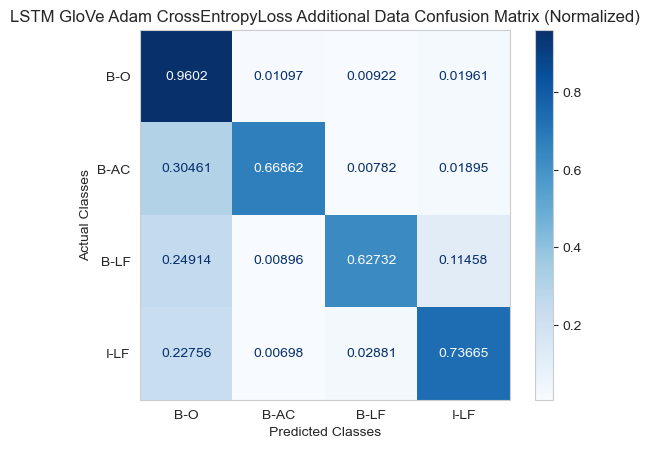

In [42]:
plot_cm(model, test_data_loader, DEVICE, 4, "LSTM GloVe Adam CrossEntropyLoss Additional Data")

Run the tests and evaluations on the original test set to compare with other models.

In [262]:
# run test_model
test_model(model, test_data_loader_original, criterion, DEVICE)

Test Loss: 0.1990
Accuracy: 0.9371
Overall F1: 0.9359


,precision,recall,f1,support
B-O,0.969484,0.962255,0.965856,4292
B-AC,0.798507,0.792593,0.795539,270
B-LF,0.686275,0.700000,0.693069,150
I-LF,0.711599,0.788194,0.747941,288


In [263]:
evaluate_seqeval(model, test_data_loader_original, DEVICE, ner_tag_vocab)

              precision    recall  f1-score   support

          AC       0.80      0.79      0.80       270
          LF       0.63      0.64      0.64       152
           O       0.97      0.96      0.97      4292

   micro avg       0.95      0.94      0.95      4714
   macro avg       0.80      0.80      0.80      4714
weighted avg       0.95      0.94      0.95      4714



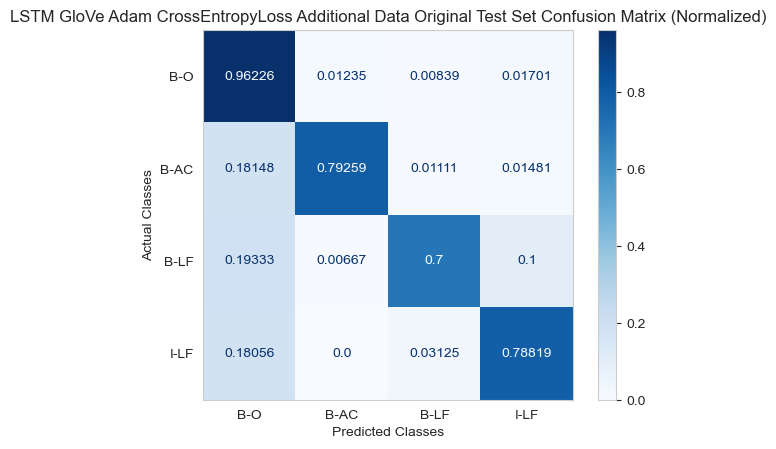

In [50]:
plot_cm(model, test_data_loader_original, DEVICE, 4, "LSTM GloVe Adam CrossEntropyLoss Additional Data Original Test Set")

{'input_dim': 25004,
 'pos_dim': 20,
 'output_dim': 7,
 'emb_dim': 100,
 'hid_dim': 256,
 'n_layers': 2,
 'dropout': 0.5,
 'bidirectional': True,
 'parameters': 5879255,
 'rnn_type': 'lstm',
 'vocab_name': 'glove',
 'max_vocab_size': 25000,
 'pretrained_emb': True,
 'batch_size': 64,
 'n_epochs': 100,
 'clip': 1,
 'teacher_forcing_ratio': 0.5,
 'optimizer': 'Adam (\nParameter Group 0\n    amsgrad: False\n    betas: (0.9, 0.999)\n    capturable: False\n    differentiable: False\n    eps: 1e-08\n    foreach: None\n    fused: None\n    lr: 0.001\n    maximize: False\n    weight_decay: 0\n)',
 'loss_function': 'CrossEntropyLoss()',
 'class_labels': ['B-O', 'B-AC', 'B-LF', 'I-LF']}

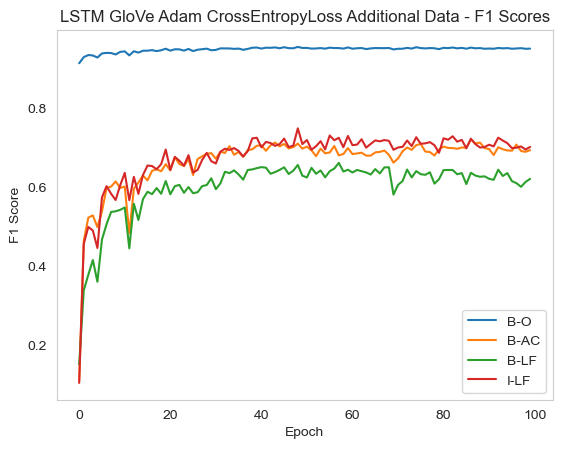

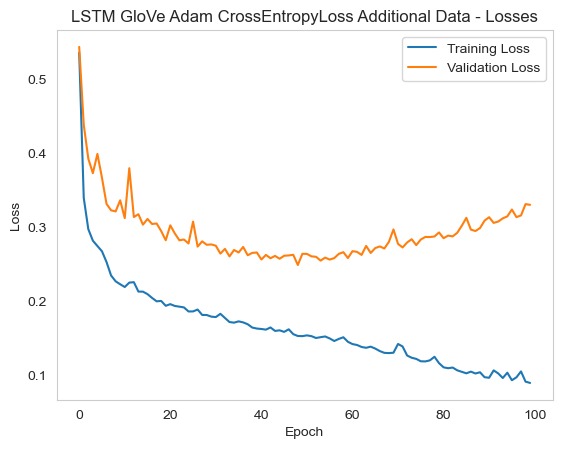

In [40]:
plot_metrics(model_file_path, 4, "LSTM GloVe Adam CrossEntropyLoss Additional Data")

### References

Some of the code in this file was adapted from https://github.com/bentrevett/pytorch-seq2seq/blob/main/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb